In [1]:
# import tensorflow as tf
# from tensorflow.keras import layers

# print('tensorflow version: {}'.format(tf.__version__))
# print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU 사용 가능 여부: False


In [ ]:
# def normalization(df, columns, mode='z'):
#     if mode == 'm' :
#         for colname in columns:
#             df[colname] = (df[colname] - df[colname].min())/(df[colname].max()-df[colname].min())
#         return df
#     if mode == 'z' :
#         for colname in columns:
#             df[colname] = (df[colname] - df[colname].mean())/df[colname].std()
#         return df

# 데이터 업로드

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import cm
import os as os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
import scipy as sp
from scipy.special import boxcox1p
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
import warnings
warnings.filterwarnings(action='ignore')

In [76]:
# 기본 설정 읽기
import matplotlib.pyplot as plt

# size, family
print('# 설정되어있는 폰트 사이즈')
print (plt.rcParams['font.size'] ) 
print('# 설정되어있는 폰트 글꼴')
print (plt.rcParams['font.family'] )

# 설정되어있는 폰트 사이즈
10.0
# 설정되어있는 폰트 글꼴
['Malgun Gothic']


In [77]:
import platform
platform.system()

'Windows'

In [78]:
# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

In [79]:
# os.chdir('C:/Users/82109/Desktop')
os.chdir('C:/Users/HOME/Desktop/빅콘')

In [335]:
df = pd.read_excel('df2019.xlsx')

In [336]:
df = df.astype({'mot_code':'object','product_code':'object','month':'object'})

In [337]:
df.head(1)

,date,exposure,mot_code,product_code,product_name,group,product_detail,brand,price,tot_price,...,search for coronavirus,exchange rate,interest rate,average precipitation,day_night2,holiday,hour2,hour3,hour4,cluster_count
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,상의,테이트,39900,2099000,...,0.01336,1118.1,1.9,0.00625,오전,0,6,B,B,4


In [338]:
# 요일 그룹 재범주화
conditionlist = [
    (df['dow'] == '화요일') | (df['dow'] == '수요일') | (df['dow'] == '월요일'),
    (df['dow'] == '목요일') | (df['dow'] == '금요일'),
    (df['dow'] == '토요일') | (df['dow'] == '일요일')]
choicelist = ['월화수','목금','토일']
df['group_dow2'] = np.select(conditionlist, choicelist, default='Not Specified')

In [339]:
# 디테일 간 판매수량 차이 비율(1)
group_detail = pd.DataFrame(df.groupby(['detail','group'])['sales'].mean())
group_detail.reset_index(inplace = True)
group_detail_0 = group_detail[group_detail['detail'] == 0].set_index('group').drop(columns = ['detail'])
group_detail_1 = group_detail[group_detail['detail'] == 1].set_index('group').drop(columns = ['detail'])
group_detail = group_detail_1 - group_detail_0 / group_detail_0
group_detail.reset_index(inplace = True)
group_detail.rename({'sales':'group_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,group_detail, on = 'group',how = 'left')

# 디테일 간 판매수량 차이 (2)
hour_detail = pd.DataFrame(df.groupby(['detail','hour'])['sales'].mean())
hour_detail.reset_index(inplace = True)
hour_detail_0 = hour_detail[hour_detail['detail'] == 0].set_index('hour').drop(columns = ['detail'])
hour_detail_1 = hour_detail[hour_detail['detail'] == 1].set_index('hour').drop(columns = ['detail'])
hour_detail = hour_detail_1 - hour_detail_0 / hour_detail_0
hour_detail.reset_index(inplace = True)
hour_detail.rename({'sales':'hour_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,hour_detail, on = 'hour',how = 'left')

# 디테일 간 판매수량 차이 (3)
dow_detail = pd.DataFrame(df.groupby(['detail','dow'])['sales'].mean())
dow_detail.reset_index(inplace = True)
dow_detail_0 = dow_detail[dow_detail['detail'] == 0].set_index('dow').drop(columns = ['detail'])
dow_detail_1 = dow_detail[dow_detail['detail'] == 1].set_index('dow').drop(columns = ['detail'])
dow_detail = dow_detail_1 - dow_detail_0 / dow_detail_0
dow_detail.reset_index(inplace = True)
dow_detail.rename({'sales':'dow_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,dow_detail, on = 'dow',how = 'left')

# 디테일 간 판매수량 차이 (4)
day_night_detail = pd.DataFrame(df.groupby(['detail','day_night'])['sales'].mean())
day_night_detail.reset_index(inplace = True)
day_night_detail_0 = day_night_detail[day_night_detail['detail'] == 0].set_index('day_night').drop(columns = ['detail'])
day_night_detail_1 = day_night_detail[day_night_detail['detail'] == 1].set_index('day_night').drop(columns = ['detail'])
day_night_detail = day_night_detail_1 - day_night_detail_0 / day_night_detail_0
day_night_detail.reset_index(inplace = True)
day_night_detail.rename({'sales':'day_night_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,day_night_detail, on = 'day_night',how = 'left')

# 디테일 간 판매수량 차이 (5)
day_night2_detail = pd.DataFrame(df.groupby(['detail','day_night2'])['sales'].mean())
day_night2_detail.reset_index(inplace = True)
day_night2_detail_0 = day_night2_detail[day_night2_detail['detail'] == 0].set_index('day_night2').drop(columns = ['detail'])
day_night2_detail_1 = day_night2_detail[day_night2_detail['detail'] == 1].set_index('day_night2').drop(columns = ['detail'])
day_night2_detail = day_night2_detail_1 - day_night2_detail_0 / day_night2_detail_0
day_night2_detail.reset_index(inplace = True)
day_night2_detail.rename({'sales':'day_night2_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,day_night2_detail, on = 'day_night2',how = 'left')

# 디테일 간 판매수량 차이 (6)
group_dow_detail = pd.DataFrame(df.groupby(['detail','group_dow'])['sales'].mean())
group_dow_detail.reset_index(inplace = True)
group_dow_detail_0 = group_dow_detail[group_dow_detail['detail'] == 0].set_index('group_dow').drop(columns = ['detail'])
group_dow_detail_1 = group_dow_detail[group_dow_detail['detail'] == 1].set_index('group_dow').drop(columns = ['detail'])
group_dow_detail = group_dow_detail_1 - group_dow_detail_0 / group_dow_detail_0
group_dow_detail.reset_index(inplace = True)
group_dow_detail.rename({'sales':'group_dow_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,group_dow_detail, on = 'group_dow',how = 'left')

# 디테일 간 판매수량 차이 (7)
group_dow2_detail = pd.DataFrame(df.groupby(['detail','group_dow2'])['sales'].mean())
group_dow2_detail.reset_index(inplace = True)
group_dow2_detail_0 = group_dow2_detail[group_dow2_detail['detail'] == 0].set_index('group_dow2').drop(columns = ['detail'])
group_dow2_detail_1 = group_dow2_detail[group_dow2_detail['detail'] == 1].set_index('group_dow2').drop(columns = ['detail'])
group_dow2_detail = group_dow2_detail_1 - group_dow2_detail_0 / group_dow2_detail_0
group_dow2_detail.reset_index(inplace = True)
group_dow2_detail.rename({'sales':'group_dow2_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,group_dow2_detail, on = 'group_dow2',how = 'left')

# 디테일 간 판매수량 차이 (8)
month_detail = pd.DataFrame(df.groupby(['detail','month'])['sales'].mean())
month_detail.reset_index(inplace = True)
month_detail_0 = month_detail[month_detail['detail'] == 0].set_index('month').drop(columns = ['detail'])
month_detail_1 = month_detail[month_detail['detail'] == 1].set_index('month').drop(columns = ['detail'])
month_detail = month_detail_1 - month_detail_0 / month_detail_0
month_detail.reset_index(inplace = True)
month_detail.rename({'sales':'month_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,month_detail, on = 'month',how = 'left')

In [340]:
df.columns

Index(['date', 'exposure', 'mot_code', 'product_code', 'product_name', 'group',
       'product_detail', 'brand', 'price', 'tot_price', 'sales', 'hour', 'dow',
       'group_dow', 'ratings', 'early', 'month', 'season', 'day_night',
       'group_time1', 'group_time2', 'group_exposure', 'detail', 'temperature',
       'test', 'rating_mean', 'search for coronavirus', 'exchange rate',
       'interest rate', 'average precipitation', 'day_night2', 'holiday',
       'hour2', 'hour3', 'hour4', 'cluster_count', 'group_dow2',
       'group_detail', 'hour_detail', 'dow_detail', 'day_night_detail',
       'day_night2_detail', 'group_dow_detail', 'group_dow2_detail',
       'month_detail'],
      dtype='object')

In [341]:
# # 변수 별 판매량 평균(1)
# sales_group = pd.DataFrame(df.groupby('group')['sales'].mean())
# sales_group.rename({'sales':'sales_group'},axis = 1 ,inplace = True)
# sales_group.reset_index(inplace = True)
# df = pd.merge(df,sales_group, on = 'group',how = 'left')

In [342]:
# # 변수 별 판매량 평균(2)
# sales_hour = pd.DataFrame(df.groupby('hour')['sales'].mean())
# sales_hour.rename({'sales':'sales_hour'},axis = 1 ,inplace = True)
# sales_hour.reset_index(inplace = True)
# df = pd.merge(df,sales_hour, on = 'hour',how = 'left')

In [343]:
# # 변수 별 판매량 평균(3)
# sales_dow = pd.DataFrame(df.groupby('dow')['sales'].mean())
# sales_dow.rename({'sales':'sales_dow'},axis = 1 ,inplace = True)
# sales_dow.reset_index(inplace = True)
# df = pd.merge(df,sales_dow, on = 'dow',how = 'left')

In [344]:
# # 변수 별 판매량 평균(4)
# sales_day_night = pd.DataFrame(df.groupby('day_night')['sales'].mean())
# sales_day_night.rename({'sales':'sales_day_night'},axis = 1 ,inplace = True)
# sales_day_night.reset_index(inplace = True)
# df = pd.merge(df,sales_day_night, on = 'day_night',how = 'left')

In [345]:
# # 변수 별 판매량 평균(5)
# sales_day_night2 = pd.DataFrame(df.groupby('day_night2')['sales'].mean())
# sales_day_night2.rename({'sales':'sales_day_night2'},axis = 1 ,inplace = True)
# sales_day_night2.reset_index(inplace = True)
# df = pd.merge(df,sales_day_night2, on = 'day_night2',how = 'left')

In [346]:
# # 변수 별 판매량 평균(6)
# sales_group_dow = pd.DataFrame(df.groupby('group_dow')['sales'].mean())
# sales_group_dow.rename({'sales':'sales_group_dow'},axis = 1 ,inplace = True)
# sales_group_dow.reset_index(inplace = True)
# df = pd.merge(df,sales_group_dow, on = 'group_dow',how = 'left')

In [347]:
# # 변수 별 판매량 평균(7)
# sales_group_dow2 = pd.DataFrame(df.groupby('group_dow2')['sales'].mean())
# sales_group_dow2.rename({'sales':'sales_group_dow2'},axis = 1 ,inplace = True)
# sales_group_dow2.reset_index(inplace = True)
# df = pd.merge(df,sales_group_dow2, on = 'group_dow2',how = 'left')

In [348]:
# # 변수 별 판매량 평균(8)
# sales_month = pd.DataFrame(df.groupby('month')['sales'].mean())
# sales_month.rename({'sales':'sales_month'},axis = 1 ,inplace = True)
# sales_month.reset_index(inplace = True)
# df = pd.merge(df,sales_month, on = 'month',how = 'left')

In [349]:
df.columns

Index(['date', 'exposure', 'mot_code', 'product_code', 'product_name', 'group',
       'product_detail', 'brand', 'price', 'tot_price', 'sales', 'hour', 'dow',
       'group_dow', 'ratings', 'early', 'month', 'season', 'day_night',
       'group_time1', 'group_time2', 'group_exposure', 'detail', 'temperature',
       'test', 'rating_mean', 'search for coronavirus', 'exchange rate',
       'interest rate', 'average precipitation', 'day_night2', 'holiday',
       'hour2', 'hour3', 'hour4', 'cluster_count', 'group_dow2',
       'group_detail', 'hour_detail', 'dow_detail', 'day_night_detail',
       'day_night2_detail', 'group_dow_detail', 'group_dow2_detail',
       'month_detail'],
      dtype='object')

In [350]:
# 상품군별 빈도수 대비 판매량
sales_group_count = df[['sales','group']]
sales_group_count.set_index('group',inplace = True)
sales_group_count['count'] = df['group'].value_counts()
sales_group_count['sales_group_count'] = sales_group_count['sales'] / sales_group_count['count']
sales_group_count.reset_index(inplace = True)
df['sales_group_count'] = sales_group_count['sales_group_count']


# 시간대별 빈도수 대비 판매량
sales_hour_count = df[['sales','hour']]
sales_hour_count.set_index('hour',inplace = True)
sales_hour_count['count'] = df['hour'].value_counts()
sales_hour_count['sales_hour_count'] = sales_hour_count['sales'] / sales_hour_count['count']
sales_hour_count.reset_index(inplace = True)
df['sales_hour_count'] = sales_hour_count['sales_hour_count']


# 요일별 빈도수 대비 판매량
sales_dow_count = df[['sales','dow']]
sales_dow_count.set_index('dow',inplace = True)
sales_dow_count['count'] = df['dow'].value_counts()
sales_dow_count['sales_dow_count'] = sales_dow_count['sales'] / sales_dow_count['count']
sales_dow_count.reset_index(inplace = True)
df['sales_dow_count'] = sales_dow_count['sales_dow_count']


# 시간대별 빈도수 대비 판매량
sales_day_night_count = df[['sales','day_night']]
sales_day_night_count.set_index('day_night',inplace = True)
sales_day_night_count['count'] = df['day_night'].value_counts()
sales_day_night_count['sales_day_night_count'] = sales_day_night_count['sales'] / sales_day_night_count['count']
sales_day_night_count.reset_index(inplace = True)
df['sales_day_night_count'] = sales_day_night_count['sales_day_night_count']


# 시간대별 빈도수 대비 판매량2
sales_day_night2_count = df[['sales','day_night2']]
sales_day_night2_count.set_index('day_night2',inplace = True)
sales_day_night2_count['count'] = df['day_night2'].value_counts()
sales_day_night2_count['sales_day_night2_count'] = sales_day_night2_count['sales'] / sales_day_night2_count['count']
sales_day_night2_count.reset_index(inplace = True)
df['sales_day_night2_count'] = sales_day_night2_count['sales_day_night2_count']


# 그룹요일별 빈도수 대비 판매량
sales_group_dow_count = df[['sales','group_dow']]
sales_group_dow_count.set_index('group_dow',inplace = True)
sales_group_dow_count['count'] = df['group_dow'].value_counts()
sales_group_dow_count['sales_group_dow_count'] = sales_group_dow_count['sales'] / sales_group_dow_count['count']
sales_group_dow_count.reset_index(inplace = True)
df['sales_group_dow_count'] = sales_group_dow_count['sales_group_dow_count']


# 그룹요일별 빈도수 대비 판매량2
sales_group_dow2_count = df[['sales','group_dow2']]
sales_group_dow2_count.set_index('group_dow2',inplace = True)
sales_group_dow2_count['count'] = df['group_dow2'].value_counts()
sales_group_dow2_count['sales_group_dow2_count'] = sales_group_dow2_count['sales'] / sales_group_dow2_count['count']
sales_group_dow2_count.reset_index(inplace = True)
df['sales_group_dow2_count'] = sales_group_dow2_count['sales_group_dow2_count']

# 월별 빈도수 대비 판매량

sales_month_count = df[['sales','month']]
sales_month_count.set_index('month',inplace = True)
sales_month_count['count'] = df['month'].value_counts()
sales_month_count['sales_month_count'] = sales_month_count['sales'] / sales_month_count['count']
sales_month_count.reset_index(inplace = True)
df['sales_month_count'] = sales_month_count['sales_month_count']

In [351]:
df.columns

Index(['date', 'exposure', 'mot_code', 'product_code', 'product_name', 'group',
       'product_detail', 'brand', 'price', 'tot_price', 'sales', 'hour', 'dow',
       'group_dow', 'ratings', 'early', 'month', 'season', 'day_night',
       'group_time1', 'group_time2', 'group_exposure', 'detail', 'temperature',
       'test', 'rating_mean', 'search for coronavirus', 'exchange rate',
       'interest rate', 'average precipitation', 'day_night2', 'holiday',
       'hour2', 'hour3', 'hour4', 'cluster_count', 'group_dow2',
       'group_detail', 'hour_detail', 'dow_detail', 'day_night_detail',
       'day_night2_detail', 'group_dow_detail', 'group_dow2_detail',
       'month_detail', 'sales_group_count', 'sales_hour_count',
       'sales_dow_count', 'sales_day_night_count', 'sales_day_night2_count',
       'sales_group_dow_count', 'sales_group_dow2_count', 'sales_month_count'],
      dtype='object')

In [352]:
# # 변수 별 빈도수 비율(1)

# sales_dow_count['dow_count_ratio'] = sales_dow_count['count'] / 35378

# sales_group_dow_count['group_dow_count_ratio'] = sales_group_dow_count['count'] / 35378

# sales_group_dow2_count['group_dow2_count_ratio'] = sales_group_dow2_count['count'] / 35378

# sales_hour_count['hour_count_ratio'] = sales_hour_count['count'] / 35378

# sales_day_night_count['day_night_count_ratio'] = sales_day_night_count['count'] / 35378

In [353]:
# # 변수 별 빈도수 비율(2)

# df['dow_count_ratio'] = sales_dow_count['dow_count_ratio']

# df['group_dow_count_ratio'] = sales_group_dow_count['group_dow_count_ratio']

# df['group_dow2_count_ratio'] = sales_group_dow2_count['group_dow2_count_ratio']

# df['hour_count_ratio'] = sales_hour_count['hour_count_ratio']

# df['day_night_count_ratio'] = sales_day_night_count['day_night_count_ratio']

In [354]:
# 변수 별 빈도수 비율(1)
group_count_ratio = pd.DataFrame(df['group'].value_counts()/35378)
group_count_ratio.reset_index(inplace = True)
group_count_ratio.rename(columns = {'index':'group','group':'group_count_ratio'},inplace = True)
df = pd.merge(df,group_count_ratio, on = 'group',how = 'left')

# 변수 별 빈도수 비율(2)
dow_count_ratio = pd.DataFrame(df['dow'].value_counts()/35378)
dow_count_ratio.reset_index(inplace = True)
dow_count_ratio.rename(columns = {'index':'dow','dow':'dow_count_ratio'},inplace = True)
df = pd.merge(df,dow_count_ratio, on = 'dow',how = 'left')

# 변수 별 빈도수 비율(3)
group_dow_count_ratio = pd.DataFrame(df['group_dow'].value_counts()/35378)
group_dow_count_ratio.reset_index(inplace = True)
group_dow_count_ratio.rename(columns = {'index':'group_dow','group_dow':'group_dow_count_ratio'},inplace = True)
df = pd.merge(df,group_dow_count_ratio, on = 'group_dow',how = 'left')

# 변수 별 빈도수 비율(4)
group_dow2_count_ratio = pd.DataFrame(df['group_dow2'].value_counts()/35378)
group_dow2_count_ratio.reset_index(inplace = True)
group_dow2_count_ratio.rename(columns = {'index':'group_dow2','group_dow2':'group_dow2_count_ratio'},inplace = True)
df = pd.merge(df,group_dow2_count_ratio, on = 'group_dow2',how = 'left')

# 변수 별 빈도수 비율(5)
hour_count_ratio = pd.DataFrame(df['hour'].value_counts()/35378)
hour_count_ratio.reset_index(inplace = True)
hour_count_ratio.rename(columns = {'index':'hour','hour':'hour_count_ratio'},inplace = True)
df = pd.merge(df,hour_count_ratio, on = 'hour',how = 'left')

# 변수 별 빈도수 비율(6)
day_night_count_ratio = pd.DataFrame(df['day_night'].value_counts()/35378)
day_night_count_ratio.reset_index(inplace = True)
day_night_count_ratio.rename(columns = {'index':'day_night','day_night':'day_night_count_ratio'},inplace = True)
df = pd.merge(df,day_night_count_ratio, on = 'day_night',how = 'left')

# 변수 별 빈도수 비율(7)
day_night2_count_ratio = pd.DataFrame(df['day_night2'].value_counts()/35378)
day_night2_count_ratio.reset_index(inplace = True)
day_night2_count_ratio.rename(columns = {'index':'day_night2','day_night2':'day_night2_count_ratio'},inplace = True)
df = pd.merge(df,day_night2_count_ratio, on = 'day_night2',how = 'left')

# 변수 별 빈도수 비율(8)
mot_code_count_ratio = pd.DataFrame(df['mot_code'].value_counts()/35378)
mot_code_count_ratio.reset_index(inplace = True)
mot_code_count_ratio.rename(columns = {'index':'mot_code','mot_code':'mot_code_count_ratio'},inplace = True)
df = pd.merge(df,mot_code_count_ratio, on = 'mot_code',how = 'left')

# 변수 별 빈도수 비율(9)
product_code_count_ratio = pd.DataFrame(df['product_code'].value_counts()/35378)
product_code_count_ratio.reset_index(inplace = True)
product_code_count_ratio.rename(columns = {'index':'product_code','product_code':'product_code_count_ratio'},inplace = True)
df = pd.merge(df,product_code_count_ratio, on = 'product_code',how = 'left')

# 변수 별 빈도수 비율(10)
month_count_ratio = pd.DataFrame(df['month'].value_counts()/35378)
month_count_ratio.reset_index(inplace = True)
month_count_ratio.rename(columns = {'index':'month','month':'month_count_ratio'},inplace = True)
df = pd.merge(df,month_count_ratio, on = 'month',how = 'left')

In [101]:
df.columns

Index(['date', 'exposure', 'mot_code', 'product_code', 'product_name', 'group',
       'product_detail', 'brand', 'price', 'tot_price', 'sales', 'hour', 'dow',
       'group_dow', 'ratings', 'early', 'month', 'season', 'day_night',
       'group_time1', 'group_time2', 'group_exposure', 'detail', 'temperature',
       'test', 'rating_mean', 'search for coronavirus', 'exchange rate',
       'interest rate', 'average precipitation', 'day_night2', 'holiday',
       'hour2', 'hour3', 'hour4', 'cluster_count', 'group_dow2',
       'group_detail', 'hour_detail', 'dow_detail', 'day_night_detail',
       'day_night2_detail', 'group_dow_detail', 'group_dow2_detail',
       'month_detail', 'sales_group_count', 'sales_hour_count',
       'sales_dow_count', 'sales_day_night_count', 'sales_day_night2_count',
       'sales_group_dow_count', 'sales_group_dow2_count', 'sales_month_count',
       'group_count_ratio', 'dow_count_ratio', 'group_dow_count_ratio',
       'group_dow2_count_ratio', 'hour_coun

In [103]:
df_train = df[[ 'group', 'ratings','rating_mean','price',
       'product_detail', 'sales', 'hour', 'dow',
       'group_dow','group_dow2', 'early', 'day_night',
       'group_time1', 'group_time2', 'detail', 
       'test', 'day_night2', 'holiday', 'month',
       'hour2', 'hour3', 'hour4','cluster_count',
               
        'sales_group_count', 'sales_hour_count',
       'sales_dow_count', 'sales_day_night_count', 'sales_day_night2_count',
       'sales_group_dow_count', 'sales_group_dow2_count', 'sales_month_count',
               
#         'sales_dow', 'sales_day_night', 'sales_day_night2','sales_group', 'sales_hour',
#        'sales_group_dow', 'sales_group_dow2','sales_month',
               
        'dow_count_ratio', 'group_dow_count_ratio', 'group_count_ratio',
       'group_dow2_count_ratio', 'hour_count_ratio', 'day_night_count_ratio',
        'mot_code_count_ratio', 'product_code_count_ratio','day_night2_count_ratio','month_count_ratio',
               
        'group_detail', 'hour_detail',
       'dow_detail', 'day_night_detail', 'day_night2_detail',
       'group_dow_detail', 'group_dow2_detail','month_detail',
               
       'search for coronavirus','exchange rate','interest rate', 'average precipitation','temperature']]

In [104]:
# df_train = df[[ 'group', 'ratings','rating_mean','price',
#        'product_detail', 'sales', 'hour', 'dow',
#        'group_dow', 'early', 'day_night',
#        'group_time1', 'group_time2', 'detail', 
#        'test', 'day_night2', 'holiday',
#        'hour2', 'hour3', 'hour4', 'sales_group', 'sales_hour',
#        'sales_dow', 'sales_day_night', 'sales_day_night2',
#        'sales_group_dow', 'group_dow2', 'sales_group_dow2',
#         'dow_count_ratio', 'group_dow_count_ratio', 'group_count_ratio',
#        'group_dow2_count_ratio', 'hour_count_ratio', 'day_night_count_ratio',
#         'mot_code_count_ratio', 'product_code_count_ratio','day_night2_count_ratio',
#        'search for coronavirus','exchange rate','interest rate', 'average precipitation','temperature']]

In [105]:
df_train.head(2)
# LabelEncoding : 'group', 'product_detail', 'dow', 'day_night','day_night2','group_time1' , 'group_time2' , 'hour3', 'hour4', 'group_dow2'

,group,ratings,rating_mean,price,product_detail,sales,hour,dow,group_dow,group_dow2,...,day_night_detail,day_night2_detail,group_dow_detail,group_dow2_detail,month_detail,search for coronavirus,exchange rate,interest rate,average precipitation,temperature
0,의류,0.0,0.0,39900,상의,52.606516,6,화요일,2,월화수,...,457.960894,457.960894,384.483046,386.212341,444.823259,0.01336,1118.1,1.9,0.00625,-3.7
1,의류,0.0,0.0,39900,상의,109.548872,6,화요일,2,월화수,...,457.960894,457.960894,384.483046,386.212341,444.823259,0.01336,1118.1,1.9,0.00625,-3.7


In [106]:
# 기상요인 및 경제요인 변수의 기술통계량
# df_train[['temperature','search for coronavirus', 'exchange rate',
#        'interest rate', 'average precipitation']].describe()

### 범주형 변수 LabelEncoding

In [107]:
le1 = LabelEncoder()

df_train['group'] = le1.fit_transform(df_train['group'])

df_train['product_detail'] = le1.fit_transform(df_train['product_detail'])

df_train['dow'] = le1.fit_transform(df_train['dow'])

df_train['group_dow2'] = le1.fit_transform(df_train['group_dow2'])

df_train['day_night'] = le1.fit_transform(df_train['day_night'])

df_train['day_night2'] = le1.fit_transform(df_train['day_night2'])

df_train['group_time1'] = le1.fit_transform(df_train['group_time1'])

df_train['group_time2'] = le1.fit_transform(df_train['group_time2'])

df_train['hour3'] = le1.fit_transform(df_train['hour3'])

df_train['hour4'] = le1.fit_transform(df_train['hour4'])

### 범주형 변수 OnehotEncoding

In [108]:
df_train['group'] = pd.get_dummies(df_train['group'])

df_train['product_detail'] = pd.get_dummies(df_train['product_detail'])

df_train['dow'] = pd.get_dummies(df_train['dow'])

df_train['group_dow2'] = pd.get_dummies(df_train['group_dow2'])

df_train['day_night'] = pd.get_dummies(df_train['day_night'])

df_train['day_night2'] = pd.get_dummies(df_train['day_night2'])

df_train['group_time1'] = pd.get_dummies(df_train['group_time1'])

df_train['group_time2'] = pd.get_dummies(df_train['group_time2'])

df_train['hour3'] = pd.get_dummies(df_train['hour3'])

df_train['hour4'] = pd.get_dummies(df_train['hour4'])

df_train['group_dow'] = pd.get_dummies(df_train['group_dow'])

df_train['hour'] = pd.get_dummies(df_train['hour'])

df_train['early'] = pd.get_dummies(df_train['early'])

# df_train['group_exposure'] = pd.get_dummies(df_train['group_exposure'])

df_train['detail'] = pd.get_dummies(df_train['detail'])

df_train['holiday'] = pd.get_dummies(df_train['holiday'])

df_train['hour2'] = pd.get_dummies(df_train['hour2'])

df_train['month'] = pd.get_dummies(df_train['month'])

df_train['cluster_count'] = pd.get_dummies(df_train['cluster_count'])

### 연속형 변수 Minmax Scaling

In [109]:
df_train['price'] = (df_train['price'] - df_train['price'].min()) / (df_train['price'].max() - df_train['price'].min())

df_train['temperature'] = (df_train['temperature'] - df_train['temperature'].min()) / (df_train['temperature'].max() - df_train['temperature'].min())

df_train['search for coronavirus'] = (df_train['search for coronavirus'] - df_train['search for coronavirus'].min()) / (df_train['search for coronavirus'].max() - df_train['search for coronavirus'].min())

df_train['exchange rate'] = (df_train['exchange rate'] - df_train['exchange rate'].min()) / (df_train['exchange rate'].max() - df_train['exchange rate'].min())

df_train['interest rate'] = (df_train['interest rate'] - df_train['interest rate'].min()) / (df_train['interest rate'].max() - df_train['interest rate'].min())

## 정제변수 1 

df_train['sales_group_count'] = (df_train['sales_group_count'] - df_train['sales_group_count'].min()) / (df_train['sales_group_count'].max() - df_train['sales_group_count'].min())

df_train['sales_hour_count'] = (df_train['sales_hour_count'] - df_train['sales_hour_count'].min()) / (df_train['sales_hour_count'].max() - df_train['sales_hour_count'].min())

df_train['sales_dow_count'] = (df_train['sales_dow_count'] - df_train['sales_dow_count'].min()) / (df_train['sales_dow_count'].max() - df_train['sales_dow_count'].min())

df_train['sales_group_dow_count'] = (df_train['sales_group_dow_count'] - df_train['sales_group_dow_count'].min()) / (df_train['sales_group_dow_count'].max() - df_train['sales_group_dow_count'].min())

df_train['sales_group_dow2_count'] = (df_train['sales_group_dow2_count'] - df_train['sales_group_dow2_count'].min()) / (df_train['sales_group_dow2_count'].max() - df_train['sales_group_dow2_count'].min())

df_train['sales_month_count'] = (df_train['sales_month_count'] - df_train['sales_month_count'].min()) / (df_train['sales_month_count'].max() - df_train['sales_month_count'].min())

## 정제변수 2

# df_train['sales_group'] = (df_train['sales_group'] - df_train['sales_group'].min()) / (df_train['sales_group'].max() - df_train['sales_group'].min())

# df_train['sales_hour'] = (df_train['sales_hour'] - df_train['sales_hour'].min()) / (df_train['sales_hour'].max() - df_train['sales_hour'].min())

# df_train['sales_dow'] = (df_train['sales_dow'] - df_train['sales_dow'].min()) / (df_train['sales_dow'].max() - df_train['sales_dow'].min())

# df_train['sales_group_dow'] = (df_train['sales_group_dow'] - df_train['sales_group_dow'].min()) / (df_train['sales_group_dow'].max() - df_train['sales_group_dow'].min())

# df_train['sales_group_dow2'] = (df_train['sales_group_dow2'] - df_train['sales_group_dow2'].min()) / (df_train['sales_group_dow2'].max() - df_train['sales_group_dow2'].min())

# df_train['sales_day_night'] = (df_train['sales_day_night'] - df_train['sales_day_night'].min()) / (df_train['sales_day_night'].max() - df_train['sales_day_night'].min())

# df_train['sales_day_night2'] = (df_train['sales_day_night2'] - df_train['sales_day_night2'].min()) / (df_train['sales_day_night2'].max() - df_train['sales_day_night2'].min())

# df_train['sales_month'] = (df_train['sales_month'] - df_train['sales_month'].min()) / (df_train['sales_month'].max() - df_train['sales_month'].min())

## 정제변수 3

df_train['group_count_ratio'] = (df_train['group_count_ratio'] - df_train['group_count_ratio'].min()) / (df_train['group_count_ratio'].max() - df_train['group_count_ratio'].min())

df_train['group_dow_count_ratio'] = (df_train['group_dow_count_ratio'] - df_train['group_dow_count_ratio'].min()) / (df_train['group_dow_count_ratio'].max() - df_train['group_dow_count_ratio'].min())

df_train['group_dow2_count_ratio'] = (df_train['group_dow2_count_ratio'] - df_train['group_dow2_count_ratio'].min()) / (df_train['group_dow2_count_ratio'].max() - df_train['group_dow2_count_ratio'].min())

df_train['hour_count_ratio'] = (df_train['hour_count_ratio'] - df_train['hour_count_ratio'].min()) / (df_train['hour_count_ratio'].max() - df_train['hour_count_ratio'].min())

df_train['dow_count_ratio'] = (df_train['dow_count_ratio'] - df_train['dow_count_ratio'].min()) / (df_train['dow_count_ratio'].max() - df_train['dow_count_ratio'].min())

df_train['day_night_count_ratio'] = (df_train['day_night_count_ratio'] - df_train['day_night_count_ratio'].min()) / (df_train['day_night_count_ratio'].max() - df_train['day_night_count_ratio'].min())

df_train['day_night2_count_ratio'] = (df_train['day_night2_count_ratio'] - df_train['day_night2_count_ratio'].min()) / (df_train['day_night2_count_ratio'].max() - df_train['day_night2_count_ratio'].min())

df_train['mot_code_count_ratio'] = (df_train['mot_code_count_ratio'] - df_train['mot_code_count_ratio'].min()) / (df_train['mot_code_count_ratio'].max() - df_train['mot_code_count_ratio'].min())

df_train['product_code_count_ratio'] = (df_train['product_code_count_ratio'] - df_train['product_code_count_ratio'].min()) / (df_train['product_code_count_ratio'].max() - df_train['product_code_count_ratio'].min())

df_train['month_count_ratio'] = (df_train['month_count_ratio'] - df_train['month_count_ratio'].min()) / (df_train['month_count_ratio'].max() - df_train['month_count_ratio'].min())

## 정제변수 4

df_train['group_detail'] = (df_train['group_detail'] - df_train['group_detail'].min()) / (df_train['group_detail'].max() - df_train['group_detail'].min())

df_train['hour_detail'] = (df_train['hour_detail'] - df_train['hour_detail'].min()) / (df_train['hour_detail'].max() - df_train['hour_detail'].min())

df_train['dow_detail'] = (df_train['dow_detail'] - df_train['dow_detail'].min()) / (df_train['dow_detail'].max() - df_train['dow_detail'].min())

df_train['group_dow_detail'] = (df_train['group_dow_detail'] - df_train['group_dow_detail'].min()) / (df_train['group_dow_detail'].max() - df_train['group_dow_detail'].min())

df_train['group_dow2_detail'] = (df_train['group_dow2_detail'] - df_train['group_dow2_detail'].min()) / (df_train['group_dow2_detail'].max() - df_train['group_dow2_detail'].min())

df_train['day_night_detail'] = (df_train['day_night_detail'] - df_train['day_night_detail'].min()) / (df_train['day_night_detail'].max() - df_train['day_night_detail'].min())

df_train['day_night2_detail'] = (df_train['day_night2_detail'] - df_train['day_night2_detail'].min()) / (df_train['day_night2_detail'].max() - df_train['day_night2_detail'].min())

df_train['month_detail'] = (df_train['month_detail'] - df_train['month_detail'].min()) / (df_train['month_detail'].max() - df_train['month_detail'].min())


## train / test split (0/1) : 1번모델

In [110]:
train_idx = df_train[df_train['test']==0].index
test_idx = df_train[df_train['test']==1].index

train = df_train.loc[train_idx]
test = df_train.loc[test_idx]

train_y = train['sales']
train_X = train.drop(columns = ['sales','test'])
test_y = test['sales']
test_X = test.drop(columns = ['sales','test'])

print('train set dim: {}'.format(train_X.shape))
print('test set dim: {}'.format(test_X.shape))

train set dim: (22087, 52)
test set dim: (13291, 52)


In [183]:
mon_idx

Int64Index([  511,   512,   513,   514,   515,   516,   517,   518,   519,
              520,
            ...
            35258, 35262, 35263, 35264, 35274, 35275, 35276, 35277, 35278,
            35279],
           dtype='int64', length=3318)

In [215]:
# 요일 별 데이터셋 분할
mon_idx = train[df['dow'] == '월요일'].index
tue_idx = train[df['dow'] == '화요일'].index
wen_idx = train[df['dow'] == '수요일'].index
thu_idx = train[df['dow'] == '목요일'].index
fri_idx = train[df['dow'] == '금요일'].index
sat_idx = train[df['dow'] == '토요일'].index
sun_idx = train[df['dow'] == '일요일'].index

mon_idx2 = test[df['dow'] == '월요일'].index
tue_idx2 = test[df['dow'] == '화요일'].index
wen_idx2 = test[df['dow'] == '수요일'].index
thu_idx2 = test[df['dow'] == '목요일'].index
fri_idx2 = test[df['dow'] == '금요일'].index
sat_idx2 = test[df['dow'] == '토요일'].index
sun_idx2 = test[df['dow'] == '일요일'].index

mon_train_X = train_X.loc[mon_idx].drop(columns = ['dow'])
tue_train_X = train_X.loc[tue_idx].drop(columns = ['dow'])
wen_train_X = train_X.loc[wen_idx].drop(columns = ['dow'])
thu_train_X = train_X.loc[thu_idx].drop(columns = ['dow'])
fri_train_X = train_X.loc[fri_idx].drop(columns = ['dow'])
sat_train_X = train_X.loc[sat_idx].drop(columns = ['dow'])
sun_train_X = train_X.loc[sun_idx].drop(columns = ['dow'])

mon_train_y = train_y.loc[mon_idx]
tue_train_y = train_y.loc[tue_idx]
wen_train_y = train_y.loc[wen_idx]
thu_train_y = train_y.loc[thu_idx]
fri_train_y = train_y.loc[fri_idx]
sat_train_y = train_y.loc[sat_idx]
sun_train_y = train_y.loc[sun_idx]

mon_test_X = test_X.loc[mon_idx2].drop(columns = ['dow'])
tue_test_X = test_X.loc[tue_idx2].drop(columns = ['dow'])
wen_test_X = test_X.loc[wen_idx2].drop(columns = ['dow'])
thu_test_X = test_X.loc[thu_idx2].drop(columns = ['dow'])
fri_test_X = test_X.loc[fri_idx2].drop(columns = ['dow'])
sat_test_X = test_X.loc[sat_idx2].drop(columns = ['dow'])
sun_test_X = test_X.loc[sun_idx2].drop(columns = ['dow'])

mon_test_y = test_y.loc[mon_idx2]
tue_test_y = test_y.loc[tue_idx2]
wen_test_y = test_y.loc[wen_idx2]
thu_test_y = test_y.loc[thu_idx2]
fri_test_y = test_y.loc[fri_idx2]
sat_test_y = test_y.loc[sat_idx2]
sun_test_y = test_y.loc[sun_idx2]

In [201]:
# # 13000개만 사용
# june_idx1 = train[df['month']==6].index
# june_idx2 = test[df['month']==6].index
# june_train = train.loc[june_idx1].drop(columns = ['month'])
# june_test = test.loc[june_idx2].drop(columns = ['month'])

### k-fold CV (XGBOOST1)

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb

In [112]:
xgb_preds = []
K = 5
kf = KFold(n_splits = K, random_state = 42, shuffle = True)

In [113]:
# Model 1
for train_index, valid_index in kf.split(train):
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': False}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model1 = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


[02:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:282.659	valid-mae:280.593
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:255.872	valid-mae:253.956
[200]	train-mae:231.624	valid-mae:229.862
[300]	train-mae:209.676	valid-mae:208.048
[400]	train-mae:189.811	valid-mae:188.305
[500]	train-mae:171.829	valid-mae:170.438
[600]	train-mae:155.552	valid-mae:154.266
[700]	train-mae:140.818	valid-mae:139.635
[800]	train-mae:127.481	valid-mae:126.393
[900]	train-mae:115.409	valid-mae:114.403
[1000]	train-mae:104.484	valid-mae:103.546
[1100]	train-mae:94.5964	valid-mae:93.7137
[1200]	train-mae:85.6483	valid-mae:84.8238
[1300]	train-mae:77.5475	valid-mae:76.7765
[1400]	train-mae:70.2165	valid-mae:69.496
[1500]	train-mae:63.5797	valid-mae:62.9052
[1600]	train-mae:

[17800]	train-mae:0.355535	valid-mae:0.883298
[17900]	train-mae:0.355286	valid-mae:0.883137
[18000]	train-mae:0.355018	valid-mae:0.882982
[18100]	train-mae:0.354774	valid-mae:0.882813
[18200]	train-mae:0.354513	valid-mae:0.88265
[18300]	train-mae:0.354221	valid-mae:0.882454
[18400]	train-mae:0.35401	valid-mae:0.882328
[18500]	train-mae:0.353778	valid-mae:0.882168
[18600]	train-mae:0.35355	valid-mae:0.88203
[18700]	train-mae:0.35332	valid-mae:0.881896
[18800]	train-mae:0.353074	valid-mae:0.881747
[18900]	train-mae:0.352818	valid-mae:0.881593
[19000]	train-mae:0.352581	valid-mae:0.881431
[19100]	train-mae:0.352373	valid-mae:0.881309
[19200]	train-mae:0.352159	valid-mae:0.881148
[19300]	train-mae:0.351834	valid-mae:0.880903
[19400]	train-mae:0.351551	valid-mae:0.880713
[19500]	train-mae:0.351375	valid-mae:0.880582
[19600]	train-mae:0.351113	valid-mae:0.880393
[19700]	train-mae:0.350915	valid-mae:0.880252
[19800]	train-mae:0.350601	valid-mae:0.880052
[19900]	train-mae:0.350335	valid-mae:0.

[10500]	train-mae:0.370637	valid-mae:0.83257
[10600]	train-mae:0.369689	valid-mae:0.831921
[10700]	train-mae:0.368775	valid-mae:0.831283
[10800]	train-mae:0.367881	valid-mae:0.830711
[10900]	train-mae:0.367025	valid-mae:0.830073
[11000]	train-mae:0.366176	valid-mae:0.829498
[11100]	train-mae:0.365403	valid-mae:0.828936
[11200]	train-mae:0.36462	valid-mae:0.828382
[11300]	train-mae:0.363949	valid-mae:0.827856
[11400]	train-mae:0.363247	valid-mae:0.827406
[11500]	train-mae:0.362601	valid-mae:0.826937
[11600]	train-mae:0.361884	valid-mae:0.826474
[11700]	train-mae:0.361268	valid-mae:0.82609
[11800]	train-mae:0.360649	valid-mae:0.825663
[11900]	train-mae:0.360079	valid-mae:0.825285
[12000]	train-mae:0.359496	valid-mae:0.824919
[12100]	train-mae:0.358896	valid-mae:0.824556
[12200]	train-mae:0.358324	valid-mae:0.824183
[12300]	train-mae:0.357778	valid-mae:0.82385
[12400]	train-mae:0.357207	valid-mae:0.823496
[12500]	train-mae:0.356661	valid-mae:0.823168
[12600]	train-mae:0.356114	valid-mae:0

[2900]	train-mae:15.7614	valid-mae:16.4082
[3000]	train-mae:14.2793	valid-mae:14.9187
[3100]	train-mae:12.9377	valid-mae:13.5705
[3200]	train-mae:11.7225	valid-mae:12.3503
[3300]	train-mae:10.622	valid-mae:11.246
[3400]	train-mae:9.62586	valid-mae:10.2468
[3500]	train-mae:8.72363	valid-mae:9.34173
[3600]	train-mae:7.9066	valid-mae:8.52482
[3700]	train-mae:7.16683	valid-mae:7.78855
[3800]	train-mae:6.4972	valid-mae:7.12333
[3900]	train-mae:5.89081	valid-mae:6.52001
[4000]	train-mae:5.34167	valid-mae:5.97816
[4100]	train-mae:4.84428	valid-mae:5.4877
[4200]	train-mae:4.39389	valid-mae:5.04666
[4300]	train-mae:3.98608	valid-mae:4.64945
[4400]	train-mae:3.6169	valid-mae:4.29209
[4500]	train-mae:3.28249	valid-mae:3.96885
[4600]	train-mae:2.97983	valid-mae:3.67841
[4700]	train-mae:2.70584	valid-mae:3.41961
[4800]	train-mae:2.45788	valid-mae:3.18884
[4900]	train-mae:2.23349	valid-mae:2.98382
[5000]	train-mae:2.03073	valid-mae:2.80208
[5100]	train-mae:1.84749	valid-mae:2.64307
[5200]	train-mae:

[7300]	train-mae:0.480111	valid-mae:1.41644
[7400]	train-mae:0.469893	valid-mae:1.40835
[7500]	train-mae:0.460859	valid-mae:1.40098
[7600]	train-mae:0.452848	valid-mae:1.39438
[7700]	train-mae:0.445708	valid-mae:1.38836
[7800]	train-mae:0.439394	valid-mae:1.38294
[7900]	train-mae:0.433742	valid-mae:1.37795
[8000]	train-mae:0.428751	valid-mae:1.37343
[8100]	train-mae:0.424242	valid-mae:1.36929
[8200]	train-mae:0.420155	valid-mae:1.36545
[8300]	train-mae:0.416519	valid-mae:1.36199
[8400]	train-mae:0.413309	valid-mae:1.35874
[8500]	train-mae:0.41023	valid-mae:1.35553
[8600]	train-mae:0.407414	valid-mae:1.35261
[8700]	train-mae:0.40481	valid-mae:1.34983
[8800]	train-mae:0.402425	valid-mae:1.34715
[8900]	train-mae:0.400088	valid-mae:1.34457
[9000]	train-mae:0.398072	valid-mae:1.34212
[9100]	train-mae:0.396126	valid-mae:1.33978
[9200]	train-mae:0.394373	valid-mae:1.33767
[9300]	train-mae:0.392624	valid-mae:1.33556
[9400]	train-mae:0.390985	valid-mae:1.33361
[9500]	train-mae:0.389561	valid-ma

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:256.087	valid-mae:253.126
[200]	train-mae:231.811	valid-mae:229.155
[300]	train-mae:209.842	valid-mae:207.453
[400]	train-mae:189.96	valid-mae:187.803
[500]	train-mae:171.963	valid-mae:170.015
[600]	train-mae:155.671	valid-mae:153.912
[700]	train-mae:140.924	valid-mae:139.344
[800]	train-mae:127.576	valid-mae:126.151
[900]	train-mae:115.495	valid-mae:114.205
[1000]	train-mae:104.561	valid-mae:103.408
[1100]	train-mae:94.667	valid-mae:93.6438
[1200]	train-mae:85.7106	valid-mae:84.798
[1300]	train-mae:77.605	valid-mae:76.7876
[1400]	train-mae:70.2682	valid-mae:69.5314
[1500]	train-mae:63.6263	valid-mae:62.9617
[1600]	train-mae:57.6132	valid-mae:57.0117
[1700]	train-mae:52.1703	valid-mae:51.6227
[1800]	train-mae:47.2426	valid-mae:46.7428
[1900]	train-mae:42.7825	valid-mae:42.3363
[2000]	train-mae:38.7442	valid-mae:38.3436
[2100]	train-mae:35.088	valid-mae:34.7273
[2200]	train-mae:31.7775	valid-mae:31.4544
[2300]	tra

[18700]	train-mae:0.339399	valid-mae:1.01251
[18800]	train-mae:0.339169	valid-mae:1.01239
[18900]	train-mae:0.338927	valid-mae:1.01226
[19000]	train-mae:0.338691	valid-mae:1.01212
[19100]	train-mae:0.338485	valid-mae:1.01201
[19200]	train-mae:0.338267	valid-mae:1.01189
[19300]	train-mae:0.338065	valid-mae:1.01178
[19400]	train-mae:0.337804	valid-mae:1.01163
[19500]	train-mae:0.337592	valid-mae:1.01149
[19600]	train-mae:0.337326	valid-mae:1.01133
[19700]	train-mae:0.337132	valid-mae:1.01121
[19800]	train-mae:0.336918	valid-mae:1.01109
[19900]	train-mae:0.336732	valid-mae:1.011
[20000]	train-mae:0.336535	valid-mae:1.01088
[20100]	train-mae:0.336357	valid-mae:1.01076
[20200]	train-mae:0.336155	valid-mae:1.01065
[20300]	train-mae:0.335928	valid-mae:1.01052
[20400]	train-mae:0.335695	valid-mae:1.01038
[20500]	train-mae:0.335527	valid-mae:1.01027
[20600]	train-mae:0.335322	valid-mae:1.01017
[20700]	train-mae:0.335094	valid-mae:1.01004
[20800]	train-mae:0.334871	valid-mae:1.00989
[20900]	trai

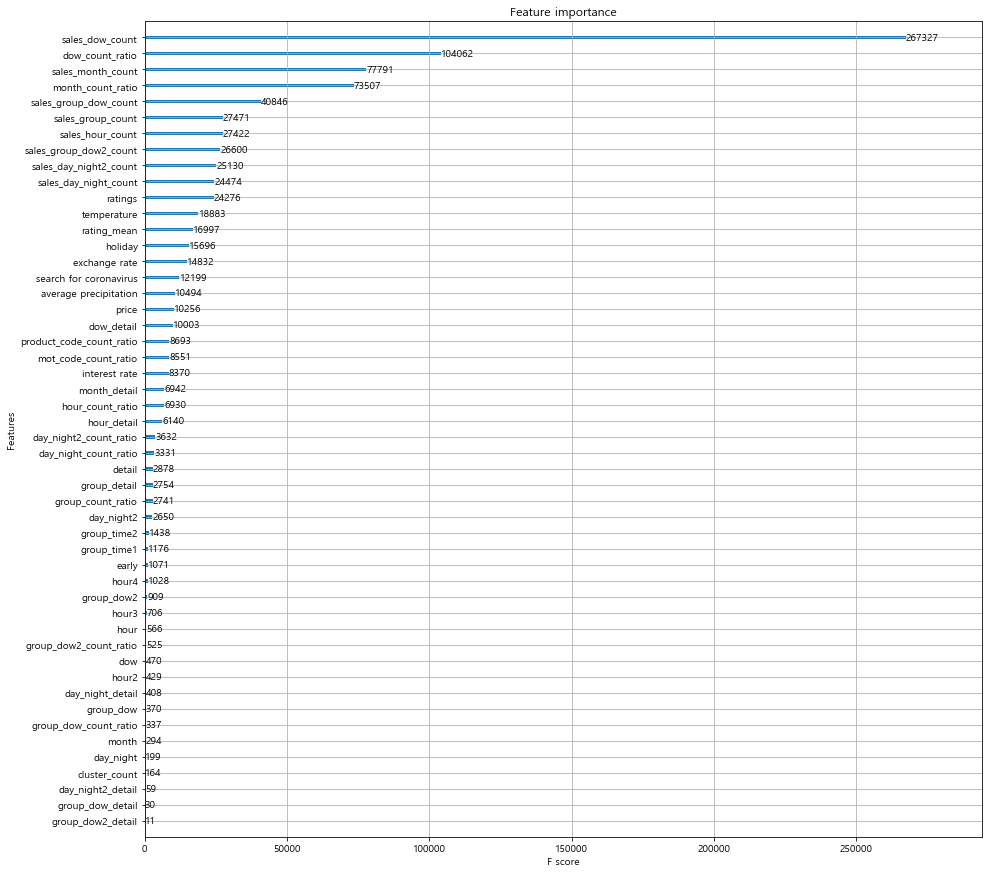

In [114]:
plt.rcParams["figure.figsize"] = (15, 15)
xgb.plot_importance(xgb_model1)

In [115]:
# CV MAE
# preds=[]
# for i in range(len(xgb_preds[0])):
#     sum=0
#     for j in range(K):
#         sum+=xgb_preds[j][i]
#     preds.append(sum / K)

# output = pd.DataFrame({'id': id_test, 'target': preds})

In [116]:
d_test = xgb.DMatrix(test_X)
xgb_pred = xgb_model1.predict(d_test)
xgb_pred

array([1214.943   , 2214.6743  , 1376.0967  , ...,   53.58768 ,
         54.287945,   51.249737], dtype=float32)

In [117]:
df_xgb_pred1 = pd.DataFrame(xgb_pred)
df_xgb_pred1.columns = ['xgb_pred1']
df_xgb_pred1

,xgb_pred1
0,1214.942993
1,2214.674316
2,1376.096680
3,1061.585327
4,1824.473022
...,...
13286,31.991676
13287,21.452471
13288,53.587681
13289,54.287945


In [118]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE(test_y, xgb_pred)

0.5845712483326099

In [119]:
xgb_pred[xgb_pred < 0]

array([], dtype=float32)

### k-fold CV (LGBM1)

In [120]:
import lightgbm as lgb

In [121]:
# Model 1
for train_index, valid_index in kf.split(train):
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]

    # params configuration also from the1owl's kernel
    # https://www.kaggle.com/the1owl/forza-baseline
    lgb_params = {'learning_rate': 0.001, 'boosting_type':'gbdt','max_depth': 10, 'min_gain_to_split':9,'min_sum_hessian_in_leaf':0.5217729, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 
                  'objective': 'regression', 'metric': 'mape', 'seed': 42 , 'force_col_wise' : 'True' }

    d_train = lgb.Dataset(X_train, y_train)
    d_valid = lgb.Dataset(X_valid, y_valid)
    
    lgb_model1 = lgb.train(lgb_params, train_set = d_train, valid_sets = d_valid,  num_boost_round = 25000,
                          verbose_eval=100, early_stopping_rounds=200)
                        
#     lgb_pred = lgb_model.predict(X_valid)
#     lgb_preds.append(list(lgb_pred))
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


Training until validation scores don't improve for 200 rounds
[100]	valid_0's mape: 8.79689
[200]	valid_0's mape: 7.97129
[300]	valid_0's mape: 7.22295
[400]	valid_0's mape: 6.54607
[500]	valid_0's mape: 5.93235
[600]	valid_0's mape: 5.37721
[700]	valid_0's mape: 4.87412
[800]	valid_0's mape: 4.41742
[900]	valid_0's mape: 4.00414
[1000]	valid_0's mape: 3.63004
[1100]	valid_0's mape: 3.29093
[1200]	valid_0's mape: 2.98296
[1300]	valid_0's mape: 2.70332
[1400]	valid_0's mape: 2.44995
[1500]	valid_0's mape: 2.22063
[1600]	valid_0's mape: 2.01318
[1700]	valid_0's mape: 1.82515
[1800]	valid_0's mape: 1.65507
[1900]	valid_0's mape: 1.50113
[2000]	valid_0's mape: 1.36149
[2100]	valid_0's mape: 1.23519
[2200]	valid_0's mape: 1.12117
[2300]	valid_0's mape: 1.01783
[2400]	valid_0's mape: 0.924103
[2500]	valid_0's mape: 0.839027
[2600]	valid_0's mape: 0.761884
[2700]	valid_0's mape: 0.692184
[2800]	valid_0's mape: 0.628941
[2900]	valid_0's mape: 0.571577
[3000]	valid_0's mape: 0.519432
[3100]	val

[3100]	valid_0's mape: 0.476773
[3200]	valid_0's mape: 0.433829
[3300]	valid_0's mape: 0.395183
[3400]	valid_0's mape: 0.359852
[3500]	valid_0's mape: 0.327966
[3600]	valid_0's mape: 0.298816
[3700]	valid_0's mape: 0.273239
[3800]	valid_0's mape: 0.249816
[3900]	valid_0's mape: 0.228099
[4000]	valid_0's mape: 0.208442
[4100]	valid_0's mape: 0.190433
[4200]	valid_0's mape: 0.174309
[4300]	valid_0's mape: 0.159377
[4400]	valid_0's mape: 0.146137
[4500]	valid_0's mape: 0.134191
[4600]	valid_0's mape: 0.1232
[4700]	valid_0's mape: 0.113125
[4800]	valid_0's mape: 0.103942
[4900]	valid_0's mape: 0.0955435
[5000]	valid_0's mape: 0.0880399
[5100]	valid_0's mape: 0.0813743
[5200]	valid_0's mape: 0.0751931
[5300]	valid_0's mape: 0.0693955
[5400]	valid_0's mape: 0.0640983
[5500]	valid_0's mape: 0.0593414
[5600]	valid_0's mape: 0.0549095
[5700]	valid_0's mape: 0.0508568
[5800]	valid_0's mape: 0.0473543
[5900]	valid_0's mape: 0.0440808
[6000]	valid_0's mape: 0.0410256
[6100]	valid_0's mape: 0.03829

[14400]	valid_0's mape: 0.0121651
[14500]	valid_0's mape: 0.0121564
[14600]	valid_0's mape: 0.0121264
[14700]	valid_0's mape: 0.0121073
[14800]	valid_0's mape: 0.0120991
[14900]	valid_0's mape: 0.0120542
[15000]	valid_0's mape: 0.012018
[15100]	valid_0's mape: 0.0120019
[15200]	valid_0's mape: 0.0119675
[15300]	valid_0's mape: 0.0119317
[15400]	valid_0's mape: 0.0119053
[15500]	valid_0's mape: 0.0118732
[15600]	valid_0's mape: 0.0118399
[15700]	valid_0's mape: 0.0118058
[15800]	valid_0's mape: 0.0117829
[15900]	valid_0's mape: 0.01176
[16000]	valid_0's mape: 0.0117355
[16100]	valid_0's mape: 0.0117138
[16200]	valid_0's mape: 0.0116948
[16300]	valid_0's mape: 0.0116732
[16400]	valid_0's mape: 0.0116504
[16500]	valid_0's mape: 0.0116453
[16600]	valid_0's mape: 0.0116424
[16700]	valid_0's mape: 0.0116419
[16800]	valid_0's mape: 0.0116413
Early stopping, best iteration is:
[16608]	valid_0's mape: 0.0116392
Training until validation scores don't improve for 200 rounds
[100]	valid_0's mape: 

In [122]:
# LGBM은 predict할 때 lgb.Dataset 함수를 사용하지 않음
lgb_pred = lgb_model1.predict(test_X)
lgb_pred

array([1225.27188612, 2718.03658395, 1351.42511595, ...,   53.17281398,
         53.93933839,   52.99174324])

In [123]:
df_lgb_pred1 = pd.DataFrame(lgb_pred)
df_lgb_pred1.columns = ['lgb_pred1']
df_lgb_pred1

,lgb_pred1
0,1225.271886
1,2718.036584
2,1351.425116
3,1051.684154
4,2738.821779
...,...
13286,31.800016
13287,21.981164
13288,53.172814
13289,53.939338


In [124]:
MAPE(test_y, lgb_pred)  ## 과적합이 상당히 심함

2.639712872246129

## train/test (Only 1) : 2번모델

In [125]:
train_idx = df_train[df_train['test']==1].index
train_1 = df_train.loc[train_idx]

print('train set dim: {}'.format(train_1.shape))

train set dim: (13291, 54)


In [126]:
df_xgb_pred1.set_index(train_idx,inplace = True)
df_lgb_pred1.set_index(train_idx,inplace = True)

In [127]:
train_1['xgb_pred1'] = df_xgb_pred1['xgb_pred1']
train_1['lgb_pred1'] = df_lgb_pred1['lgb_pred1']
train_1

,group,ratings,rating_mean,price,product_detail,sales,hour,dow,group_dow,group_dow2,...,group_dow_detail,group_dow2_detail,month_detail,search for coronavirus,exchange rate,interest rate,average precipitation,temperature,xgb_pred1,lgb_pred1
32,0,0.037,0.00760,0.004686,0,1218.176353,0,0,0,0,...,0.235813,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.198330,1214.942993,1225.271886
33,0,0.005,0.00050,0.004686,0,2313.767535,0,0,0,0,...,0.235813,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.188844,2214.674316,2718.036584
34,0,0.031,0.00305,0.006088,0,1375.295082,0,0,0,0,...,0.235813,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.188844,1376.096680,1351.425116
35,0,0.014,0.00070,0.003410,0,1061.281407,0,0,0,0,...,0.235813,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.179357,1061.585327,1051.684154
36,0,0.012,0.00085,0.003410,0,1846.582915,0,0,0,0,...,0.235813,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.170377,1824.473022,2738.821779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35367,0,0.028,0.00515,0.170035,0,32.155997,0,0,0,0,...,0.235813,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.046926,31.991676,31.800016
35368,0,0.012,0.00060,0.187718,0,21.470314,0,0,0,0,...,0.235813,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.041993,21.452471,21.981164
35369,0,0.012,0.00060,0.170035,0,53.519500,0,0,0,0,...,0.235813,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.041993,53.587681,53.172814
35372,0,0.000,0.00000,0.019603,0,54.339286,0,0,0,0,...,0.235813,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.038199,54.287945,53.939338


# 요일별로 각각의 모델 만들기

In [224]:
# Model Monday
for train_index, valid_index in kf.split(mon_train):
    X_train, X_valid = mon_train_X.iloc[train_index], mon_train_X.iloc[valid_index]
    y_train, y_valid = mon_train_y.iloc[train_index], mon_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_mon = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(mon_test_X)
xgb_pred_mon = xgb_model_mon.predict(d_test)
xgb_pred_mon

[0]	train-mae:269.278	valid-mae:260.333
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:243.9	valid-mae:235.69
[200]	train-mae:220.929	valid-mae:213.326
[300]	train-mae:200.138	valid-mae:193.087
[400]	train-mae:181.304	valid-mae:174.773
[500]	train-mae:164.248	valid-mae:158.195
[600]	train-mae:148.804	valid-mae:143.265
[700]	train-mae:134.813	valid-mae:129.762
[800]	train-mae:122.142	valid-mae:117.545
[900]	train-mae:110.663	valid-mae:106.475
[1000]	train-mae:100.265	valid-mae:96.4527
[1100]	train-mae:90.8452	valid-mae:87.3674
[1200]	train-mae:82.3131	valid-mae:79.1304
[1300]	train-mae:74.5847	valid-mae:71.6651
[1400]	train-mae:67.5821	valid-mae:64.904
[1500]	train-mae:61.2394	valid-mae:58.766
[1600]	train-mae:55.4941	valid-mae:53.2095
[1700]	train-mae:50.2915	valid-mae:48.1809
[1800]	train-mae:45.5773	valid-mae:43.6272
[1900]	train-mae:41.3069	valid-mae:39.4996
[2000]	train-

[8200]	train-mae:0.133109	valid-mae:0.40326
[8300]	train-mae:0.125287	valid-mae:0.40135
[8400]	train-mae:0.118319	valid-mae:0.399965
[8500]	train-mae:0.112251	valid-mae:0.399081
[8600]	train-mae:0.106573	valid-mae:0.398302
[8700]	train-mae:0.101315	valid-mae:0.397632
[8800]	train-mae:0.097047	valid-mae:0.397337
[8900]	train-mae:0.093224	valid-mae:0.396965
[9000]	train-mae:0.090144	valid-mae:0.396803
[9100]	train-mae:0.087673	valid-mae:0.396801
[9200]	train-mae:0.085602	valid-mae:0.396991
Stopping. Best iteration:
[9031]	train-mae:0.089273	valid-mae:0.396785

[0]	train-mae:272.106	valid-mae:249.031
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:246.462	valid-mae:225.565
[200]	train-mae:223.241	valid-mae:204.277
[300]	train-mae:202.218	valid-mae:184.988
[400]	train-mae:183.181	valid-mae:167.554
[500]	train-mae:165.941	valid-mae:151.806
[600]	train-mae:150.329	valid-mae:137.556

[6500]	train-mae:0.499664	valid-mae:1.75384
[6600]	train-mae:0.457851	valid-mae:1.71488
[6700]	train-mae:0.419806	valid-mae:1.68068
[6800]	train-mae:0.385245	valid-mae:1.64975
[6900]	train-mae:0.35395	valid-mae:1.62277
[7000]	train-mae:0.325473	valid-mae:1.59938
[7100]	train-mae:0.299307	valid-mae:1.57851
[7200]	train-mae:0.27568	valid-mae:1.56069
[7300]	train-mae:0.2544	valid-mae:1.54485
[7400]	train-mae:0.234935	valid-mae:1.53043
[7500]	train-mae:0.217364	valid-mae:1.51784
[7600]	train-mae:0.201741	valid-mae:1.50659
[7700]	train-mae:0.187463	valid-mae:1.49697
[7800]	train-mae:0.174609	valid-mae:1.48852
[7900]	train-mae:0.162863	valid-mae:1.48107
[8000]	train-mae:0.151933	valid-mae:1.4743
[8100]	train-mae:0.141842	valid-mae:1.4657
[8200]	train-mae:0.13277	valid-mae:1.45815
[8300]	train-mae:0.124976	valid-mae:1.45139
[8400]	train-mae:0.118254	valid-mae:1.44585
[8500]	train-mae:0.112014	valid-mae:1.44047
[8600]	train-mae:0.106516	valid-mae:1.43543
[8700]	train-mae:0.101423	valid-mae:1.4

[9500]	train-mae:0.077587	valid-mae:0.953922
[9600]	train-mae:0.076314	valid-mae:0.953938
[9700]	train-mae:0.075073	valid-mae:0.953882
[9800]	train-mae:0.07391	valid-mae:0.953824
[9900]	train-mae:0.072939	valid-mae:0.953856
[10000]	train-mae:0.072227	valid-mae:0.953934
Stopping. Best iteration:
[9843]	train-mae:0.073411	valid-mae:0.95379



array([ 427.02094,  605.34393, 1108.087  , ...,  670.79364, 1313.5997 ,
       1504.1227 ], dtype=float32)

In [234]:
xgb_pred_mon = pd.DataFrame(xgb_pred_mon)
xgb_pred_mon.columns = ['xgb_pred_dow']
xgb_pred_mon.set_index(mon_idx2,inplace = True)
xgb_pred_mon

In [225]:
MAPE(mon_test_y, xgb_pred_mon)

1.0138852385426012

In [226]:
# Model tueday
for train_index, valid_index in kf.split(tue_train):
    X_train, X_valid = tue_train_X.iloc[train_index], tue_train_X.iloc[valid_index]
    y_train, y_valid = tue_train_y.iloc[train_index], tue_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_tue = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(tue_test_X)
xgb_pred_tue = xgb_model_tue.predict(d_test)
xgb_pred_tue

[0]	train-mae:275.605	valid-mae:272.759
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:249.648	valid-mae:247.127
[200]	train-mae:226.139	valid-mae:223.951
[300]	train-mae:204.845	valid-mae:202.95
[400]	train-mae:185.555	valid-mae:183.919
[500]	train-mae:168.084	valid-mae:166.713
[600]	train-mae:152.258	valid-mae:151.121
[700]	train-mae:137.929	valid-mae:136.978
[800]	train-mae:124.949	valid-mae:124.16
[900]	train-mae:113.193	valid-mae:112.553
[1000]	train-mae:102.546	valid-mae:102.041
[1100]	train-mae:92.9003	valid-mae:92.5106
[1200]	train-mae:84.1642	valid-mae:83.861
[1300]	train-mae:76.2519	valid-mae:76.0203
[1400]	train-mae:69.0853	valid-mae:68.905
[1500]	train-mae:62.5929	valid-mae:62.4477
[1600]	train-mae:56.7116	valid-mae:56.599
[1700]	train-mae:51.3835	valid-mae:51.2962
[1800]	train-mae:46.5584	valid-mae:46.4916
[1900]	train-mae:42.1869	valid-mae:42.1435
[2000]	train-

[8200]	train-mae:0.118531	valid-mae:0.340586
[8300]	train-mae:0.110771	valid-mae:0.33746
[8400]	train-mae:0.103732	valid-mae:0.334787
[8500]	train-mae:0.097729	valid-mae:0.33275
[8600]	train-mae:0.092138	valid-mae:0.330964
[8700]	train-mae:0.087288	valid-mae:0.329529
[8800]	train-mae:0.083274	valid-mae:0.328586
[8900]	train-mae:0.080268	valid-mae:0.328174
[9000]	train-mae:0.077603	valid-mae:0.32784
[9100]	train-mae:0.075351	valid-mae:0.327588
[9200]	train-mae:0.073511	valid-mae:0.32748
[9300]	train-mae:0.071934	valid-mae:0.327406
[9400]	train-mae:0.0705	valid-mae:0.327359
[9500]	train-mae:0.069327	valid-mae:0.327365
[9600]	train-mae:0.068396	valid-mae:0.327436
Stopping. Best iteration:
[9429]	train-mae:0.070087	valid-mae:0.327324

[0]	train-mae:278.919	valid-mae:259.491
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:252.655	valid-mae:234.958
[200]	train-mae:228.859	valid-mae

[6800]	train-mae:0.368055	valid-mae:0.944109
[6900]	train-mae:0.336985	valid-mae:0.918659
[7000]	train-mae:0.308704	valid-mae:0.895953
[7100]	train-mae:0.283103	valid-mae:0.876069
[7200]	train-mae:0.260284	valid-mae:0.858898
[7300]	train-mae:0.23952	valid-mae:0.843897
[7400]	train-mae:0.220788	valid-mae:0.830966
[7500]	train-mae:0.203693	valid-mae:0.819629
[7600]	train-mae:0.18834	valid-mae:0.810055
[7700]	train-mae:0.174503	valid-mae:0.80202
[7800]	train-mae:0.161979	valid-mae:0.795135
[7900]	train-mae:0.150551	valid-mae:0.789136
[8000]	train-mae:0.140114	valid-mae:0.783611
[8100]	train-mae:0.130743	valid-mae:0.778884
[8200]	train-mae:0.122305	valid-mae:0.774817
[8300]	train-mae:0.114502	valid-mae:0.770753
[8400]	train-mae:0.107375	valid-mae:0.767163
[8500]	train-mae:0.101081	valid-mae:0.763723
[8600]	train-mae:0.095447	valid-mae:0.761044
[8700]	train-mae:0.090761	valid-mae:0.758837
[8800]	train-mae:0.086764	valid-mae:0.757059
[8900]	train-mae:0.083574	valid-mae:0.755723
[9000]	train-

array([1217.283   , 2022.7582  , 1374.5292  , ...,   53.47593 ,
         54.358566,   51.419907], dtype=float32)

In [243]:
xgb_pred_tue = pd.DataFrame(xgb_pred_tue)
xgb_pred_tue.columns = ['xgb_pred_dow']
xgb_pred_tue.set_index(tue_idx2,inplace = True)
xgb_pred_tue

,xgb_pred_dow
32,1217.282959
33,2022.758179
34,1374.529175
35,1060.814453
36,1827.369141
...,...
35367,32.040833
35368,21.509275
35369,53.475929
35372,54.358566


In [227]:
# Model wenday
for train_index, valid_index in kf.split(wen_train):
    X_train, X_valid = wen_train_X.iloc[train_index], wen_train_X.iloc[valid_index]
    y_train, y_valid = wen_train_y.iloc[train_index], wen_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_wen = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(wen_test_X)
xgb_pred_wen = xgb_model_wen.predict(d_test)
xgb_pred_wen

[0]	train-mae:269.061	valid-mae:273.602
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:243.812	valid-mae:247.819
[200]	train-mae:220.964	valid-mae:224.554
[300]	train-mae:200.264	valid-mae:203.503
[400]	train-mae:181.513	valid-mae:184.467
[500]	train-mae:164.521	valid-mae:167.203
[600]	train-mae:149.128	valid-mae:151.611
[700]	train-mae:135.183	valid-mae:137.493
[800]	train-mae:122.548	valid-mae:124.714
[900]	train-mae:111.1	valid-mae:113.156
[1000]	train-mae:100.727	valid-mae:102.662
[1100]	train-mae:91.3269	valid-mae:93.1129
[1200]	train-mae:82.8072	valid-mae:84.4446
[1300]	train-mae:75.0846	valid-mae:76.5807
[1400]	train-mae:68.0802	valid-mae:69.4136
[1500]	train-mae:61.7365	valid-mae:62.9396
[1600]	train-mae:55.9805	valid-mae:57.0967
[1700]	train-mae:50.7687	valid-mae:51.8103
[1800]	train-mae:46.0512	valid-mae:47.0306
[1900]	train-mae:41.7735	valid-mae:42.7039
[2000]	tra

[7700]	train-mae:0.23738	valid-mae:2.77324
[7800]	train-mae:0.222415	valid-mae:2.76528
[7900]	train-mae:0.208744	valid-mae:2.75712
[8000]	train-mae:0.196226	valid-mae:2.74781
[8100]	train-mae:0.184446	valid-mae:2.73843
[8200]	train-mae:0.173645	valid-mae:2.73014
[8300]	train-mae:0.163655	valid-mae:2.72203
[8400]	train-mae:0.155087	valid-mae:2.71563
[8500]	train-mae:0.147258	valid-mae:2.70976
[8600]	train-mae:0.140147	valid-mae:2.70325
[8700]	train-mae:0.133586	valid-mae:2.69757
[8800]	train-mae:0.128062	valid-mae:2.69258
[8900]	train-mae:0.123044	valid-mae:2.68809
[9000]	train-mae:0.118413	valid-mae:2.68383
[9100]	train-mae:0.114423	valid-mae:2.68007
[9200]	train-mae:0.110914	valid-mae:2.67629
[9300]	train-mae:0.107994	valid-mae:2.67246
[9400]	train-mae:0.105227	valid-mae:2.66922
[9500]	train-mae:0.102673	valid-mae:2.66598
[9600]	train-mae:0.10045	valid-mae:2.66298
[9700]	train-mae:0.098297	valid-mae:2.65975
[9800]	train-mae:0.096084	valid-mae:2.65664
[9900]	train-mae:0.094156	valid-ma

[9800]	train-mae:0.096242	valid-mae:2.1614
[9900]	train-mae:0.09452	valid-mae:2.158
[10000]	train-mae:0.09283	valid-mae:2.15467
[10100]	train-mae:0.091429	valid-mae:2.15148
[10200]	train-mae:0.090414	valid-mae:2.14841
[10300]	train-mae:0.089486	valid-mae:2.14561
[10400]	train-mae:0.088491	valid-mae:2.14289
[10500]	train-mae:0.087591	valid-mae:2.14023
[10600]	train-mae:0.086577	valid-mae:2.13819
[10700]	train-mae:0.085533	valid-mae:2.13682
[10800]	train-mae:0.084333	valid-mae:2.13555
[10900]	train-mae:0.083388	valid-mae:2.1344
[11000]	train-mae:0.082458	valid-mae:2.13323
[11100]	train-mae:0.081552	valid-mae:2.13213
[11200]	train-mae:0.080716	valid-mae:2.13108
[11300]	train-mae:0.080165	valid-mae:2.13019
[11400]	train-mae:0.079547	valid-mae:2.12933
[11500]	train-mae:0.079005	valid-mae:2.1285
[11600]	train-mae:0.078519	valid-mae:2.12772
[11700]	train-mae:0.077985	valid-mae:2.12693
[11800]	train-mae:0.077609	valid-mae:2.1263
[11900]	train-mae:0.077191	valid-mae:2.12581
[12000]	train-mae:0.

[11300]	train-mae:0.074302	valid-mae:1.17724
[11400]	train-mae:0.074084	valid-mae:1.17716
[11500]	train-mae:0.073941	valid-mae:1.17725
Stopping. Best iteration:
[11399]	train-mae:0.074083	valid-mae:1.17714

[0]	train-mae:271.032	valid-mae:265.718
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:245.603	valid-mae:240.558
[200]	train-mae:222.567	valid-mae:217.815
[300]	train-mae:201.705	valid-mae:197.236
[400]	train-mae:182.806	valid-mae:178.65
[500]	train-mae:165.687	valid-mae:161.835
[600]	train-mae:150.177	valid-mae:146.624
[700]	train-mae:136.129	valid-mae:132.787
[800]	train-mae:123.403	valid-mae:120.236
[900]	train-mae:111.871	valid-mae:108.849
[1000]	train-mae:101.426	valid-mae:98.5198
[1100]	train-mae:91.9675	valid-mae:89.1674
[1200]	train-mae:83.3929	valid-mae:80.6861
[1300]	train-mae:75.6187	valid-mae:73.0359
[1400]	train-mae:68.5738	valid-mae:66.1154
[1500]	train-mae:

array([ 6.838164, 42.46952 , 13.281188, ..., 19.723457, 19.723457,
       11.288736], dtype=float32)

In [244]:
xgb_pred_wen = pd.DataFrame(xgb_pred_wen)
xgb_pred_wen.columns = ['xgb_pred_dow']
xgb_pred_wen.set_index(wen_idx2,inplace = True)
xgb_pred_wen

,xgb_pred_dow
93,6.838164
94,42.469521
95,13.281188
96,9.966839
97,48.750019
...,...
35344,5.732239
35345,16.926577
35346,19.723457
35347,19.723457


In [228]:
# Model thuday
for train_index, valid_index in kf.split(thu_train):
    X_train, X_valid = thu_train_X.iloc[train_index], thu_train_X.iloc[valid_index]
    y_train, y_valid = thu_train_y.iloc[train_index], thu_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_thu = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(thu_test_X)
xgb_pred_thu = xgb_model_thu.predict(d_test)
xgb_pred_thu

[0]	train-mae:272.553	valid-mae:280.63
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:246.916	valid-mae:254.431
[200]	train-mae:223.692	valid-mae:230.609
[300]	train-mae:202.66	valid-mae:209.014
[400]	train-mae:183.613	valid-mae:189.406
[500]	train-mae:166.36	valid-mae:171.624
[600]	train-mae:150.733	valid-mae:155.502
[700]	train-mae:136.58	valid-mae:140.902
[800]	train-mae:123.757	valid-mae:127.683
[900]	train-mae:112.146	valid-mae:115.727
[1000]	train-mae:101.618	valid-mae:104.887
[1100]	train-mae:92.0862	valid-mae:95.0506
[1200]	train-mae:83.451	valid-mae:86.1102
[1300]	train-mae:75.6302	valid-mae:78.0094
[1400]	train-mae:68.5464	valid-mae:70.6551
[1500]	train-mae:62.1288	valid-mae:63.9677
[1600]	train-mae:56.3142	valid-mae:57.9062
[1700]	train-mae:51.0459	valid-mae:52.4263
[1800]	train-mae:46.2741	valid-mae:47.5094
[1900]	train-mae:41.952	valid-mae:43.0794
[2000]	train-m

[0]	train-mae:271.865	valid-mae:283.377
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:246.295	valid-mae:256.762
[200]	train-mae:223.138	valid-mae:232.629
[300]	train-mae:202.164	valid-mae:210.81
[400]	train-mae:183.166	valid-mae:191.029
[500]	train-mae:165.956	valid-mae:173.083
[600]	train-mae:150.362	valid-mae:156.8
[700]	train-mae:136.242	valid-mae:142.078
[800]	train-mae:123.45	valid-mae:128.738
[900]	train-mae:111.862	valid-mae:116.653
[1000]	train-mae:101.363	valid-mae:105.724
[1100]	train-mae:91.853	valid-mae:95.8166
[1200]	train-mae:83.2361	valid-mae:86.844
[1300]	train-mae:75.4315	valid-mae:78.7394
[1400]	train-mae:68.3577	valid-mae:71.3872
[1500]	train-mae:61.9526	valid-mae:64.727
[1600]	train-mae:56.1479	valid-mae:58.6831
[1700]	train-mae:50.8892	valid-mae:53.1983
[1800]	train-mae:46.1271	valid-mae:48.2244
[1900]	train-mae:41.8109	valid-mae:43.7173
[2000]	train-ma

[3100]	train-mae:12.982	valid-mae:14.0798
[3200]	train-mae:11.779	valid-mae:12.841
[3300]	train-mae:10.6866	valid-mae:11.7123
[3400]	train-mae:9.69601	valid-mae:10.6872
[3500]	train-mae:8.79879	valid-mae:9.7637
[3600]	train-mae:7.98643	valid-mae:8.92834
[3700]	train-mae:7.25003	valid-mae:8.17269
[3800]	train-mae:6.58159	valid-mae:7.4819
[3900]	train-mae:5.97525	valid-mae:6.85034
[4000]	train-mae:5.42627	valid-mae:6.28321
[4100]	train-mae:4.92844	valid-mae:5.7676
[4200]	train-mae:4.47719	valid-mae:5.29949
[4300]	train-mae:4.06789	valid-mae:4.87282
[4400]	train-mae:3.69676	valid-mae:4.49873
[4500]	train-mae:3.36012	valid-mae:4.18967
[4600]	train-mae:3.0546	valid-mae:3.90842
[4700]	train-mae:2.77728	valid-mae:3.65746
[4800]	train-mae:2.52573	valid-mae:3.42879
[4900]	train-mae:2.29737	valid-mae:3.2207
[5000]	train-mae:2.09032	valid-mae:3.03394
[5100]	train-mae:1.90241	valid-mae:2.86517
[5200]	train-mae:1.73201	valid-mae:2.71374
[5300]	train-mae:1.57718	valid-mae:2.57669
[5400]	train-mae:1.

[6700]	train-mae:0.441035	valid-mae:0.426679
[6800]	train-mae:0.404272	valid-mae:0.403652
[6900]	train-mae:0.371302	valid-mae:0.383426
[7000]	train-mae:0.341117	valid-mae:0.365563
[7100]	train-mae:0.313893	valid-mae:0.349814
[7200]	train-mae:0.28934	valid-mae:0.336144
[7300]	train-mae:0.267049	valid-mae:0.324679
[7400]	train-mae:0.246602	valid-mae:0.31493
[7500]	train-mae:0.228199	valid-mae:0.30665
[7600]	train-mae:0.211523	valid-mae:0.299542
[7700]	train-mae:0.196271	valid-mae:0.293283
[7800]	train-mae:0.182366	valid-mae:0.288153
[7900]	train-mae:0.169727	valid-mae:0.284043
[8000]	train-mae:0.158262	valid-mae:0.28048
[8100]	train-mae:0.147657	valid-mae:0.277568
[8200]	train-mae:0.137867	valid-mae:0.274869
[8300]	train-mae:0.129309	valid-mae:0.272623
[8400]	train-mae:0.121715	valid-mae:0.270815
[8500]	train-mae:0.114979	valid-mae:0.269424
[8600]	train-mae:0.108982	valid-mae:0.268226
[8700]	train-mae:0.10363	valid-mae:0.267187
[8800]	train-mae:0.099296	valid-mae:0.266571
[8900]	train-ma

array([514.8637  , 675.53314 , 881.47363 , ...,  39.170025,  19.78545 ,
        30.828161], dtype=float32)

In [245]:
xgb_pred_thu = pd.DataFrame(xgb_pred_thu)
xgb_pred_thu.columns = ['xgb_pred_dow']
xgb_pred_thu.set_index(thu_idx2,inplace = True)
xgb_pred_thu

,xgb_pred_dow
171,514.863708
172,675.533142
173,881.473633
188,762.433228
189,1053.718994
...,...
34972,587.157166
34973,1292.984863
35349,39.170025
35350,19.785450


In [229]:
# Model friday
for train_index, valid_index in kf.split(fri_train):
    X_train, X_valid = fri_train_X.iloc[train_index], fri_train_X.iloc[valid_index]
    y_train, y_valid = fri_train_y.iloc[train_index], fri_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_fri = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(fri_test_X)
xgb_pred_fri = xgb_model_fri.predict(d_test)
xgb_pred_fri

[0]	train-mae:277.375	valid-mae:277.928
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:251.251	valid-mae:251.72
[200]	train-mae:227.614	valid-mae:227.947
[300]	train-mae:206.212	valid-mae:206.442
[400]	train-mae:186.823	valid-mae:186.981
[500]	train-mae:169.271	valid-mae:169.381
[600]	train-mae:153.378	valid-mae:153.474
[700]	train-mae:138.983	valid-mae:139.089
[800]	train-mae:125.937	valid-mae:126.023
[900]	train-mae:114.121	valid-mae:114.192
[1000]	train-mae:103.412	valid-mae:103.459
[1100]	train-mae:93.7178	valid-mae:93.7542
[1200]	train-mae:84.9395	valid-mae:84.9705
[1300]	train-mae:76.9863	valid-mae:77.0179
[1400]	train-mae:69.7813	valid-mae:69.8173
[1500]	train-mae:63.2534	valid-mae:63.2986
[1600]	train-mae:57.3401	valid-mae:57.3876
[1700]	train-mae:51.9818	valid-mae:52.0261
[1800]	train-mae:47.1293	valid-mae:47.1554
[1900]	train-mae:42.733	valid-mae:42.7191
[2000]	tra

[8100]	train-mae:0.128917	valid-mae:2.96792
[8200]	train-mae:0.12017	valid-mae:2.96434
[8300]	train-mae:0.112385	valid-mae:2.96151
[8400]	train-mae:0.105179	valid-mae:2.95892
[8500]	train-mae:0.098997	valid-mae:2.95688
[8600]	train-mae:0.093447	valid-mae:2.95504
[8700]	train-mae:0.088814	valid-mae:2.95365
[8800]	train-mae:0.085006	valid-mae:2.95256
[8900]	train-mae:0.081608	valid-mae:2.95162
[9000]	train-mae:0.078677	valid-mae:2.95085
[9100]	train-mae:0.076271	valid-mae:2.95028
[9200]	train-mae:0.074392	valid-mae:2.94984
[9300]	train-mae:0.073159	valid-mae:2.94951
[9400]	train-mae:0.072038	valid-mae:2.94921
[9500]	train-mae:0.071021	valid-mae:2.94897
[9600]	train-mae:0.070015	valid-mae:2.94876
[9700]	train-mae:0.069063	valid-mae:2.94859
[9800]	train-mae:0.068205	valid-mae:2.94844
[9900]	train-mae:0.067577	valid-mae:2.9483
[10000]	train-mae:0.067173	valid-mae:2.94823
[10100]	train-mae:0.06695	valid-mae:2.94815
[10200]	train-mae:0.066816	valid-mae:2.94806
[10300]	train-mae:0.066697	valid

[4900]	train-mae:2.37232	valid-mae:4.32458
[5000]	train-mae:2.16173	valid-mae:4.17399
[5100]	train-mae:1.97046	valid-mae:4.04223
[5200]	train-mae:1.79687	valid-mae:3.93099
[5300]	train-mae:1.63915	valid-mae:3.83405
[5400]	train-mae:1.49595	valid-mae:3.7462
[5500]	train-mae:1.36551	valid-mae:3.67982
[5600]	train-mae:1.24723	valid-mae:3.62043
[5700]	train-mae:1.13974	valid-mae:3.56813
[5800]	train-mae:1.04169	valid-mae:3.525
[5900]	train-mae:0.952729	valid-mae:3.48221
[6000]	train-mae:0.871862	valid-mae:3.44611
[6100]	train-mae:0.79872	valid-mae:3.41662
[6200]	train-mae:0.731799	valid-mae:3.39505
[6300]	train-mae:0.671057	valid-mae:3.37625
[6400]	train-mae:0.616304	valid-mae:3.36162
[6500]	train-mae:0.566342	valid-mae:3.34981
[6600]	train-mae:0.520923	valid-mae:3.34144
[6700]	train-mae:0.479546	valid-mae:3.33451
[6800]	train-mae:0.441874	valid-mae:3.33189
[6900]	train-mae:0.407428	valid-mae:3.33185
[7000]	train-mae:0.376033	valid-mae:3.33417
Stopping. Best iteration:
[6823]	train-mae:0.4

array([   6.8372574,   22.856668 ,    6.8398876, ..., 1020.3836   ,
       1607.2017   , 1910.9985   ], dtype=float32)

In [246]:
xgb_pred_fri = pd.DataFrame(xgb_pred_fri)
xgb_pred_fri.columns = ['xgb_pred_dow']
xgb_pred_fri.set_index(fri_idx2,inplace = True)
xgb_pred_fri

,xgb_pred_dow
265,6.837257
266,22.856668
267,6.839888
268,10.133360
269,22.787052
...,...
35048,1193.829956
35049,1829.688843
35050,1020.383606
35051,1607.201660


In [230]:
# Model satday
for train_index, valid_index in kf.split(sat_train):
    X_train, X_valid = sat_train_X.iloc[train_index], sat_train_X.iloc[valid_index]
    y_train, y_valid = sat_train_y.iloc[train_index], sat_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_sat = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(sat_test_X)
xgb_pred_sat = xgb_model_sat.predict(d_test)
xgb_pred_sat

[0]	train-mae:322.32	valid-mae:312.326
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:292.198	valid-mae:282.835
[200]	train-mae:264.903	valid-mae:256.164
[300]	train-mae:240.193	valid-mae:231.985
[400]	train-mae:217.789	valid-mae:210.067
[500]	train-mae:197.484	valid-mae:190.254
[600]	train-mae:179.081	valid-mae:172.34
[700]	train-mae:162.401	valid-mae:156.103
[800]	train-mae:147.276	valid-mae:141.367
[900]	train-mae:133.564	valid-mae:128.017
[1000]	train-mae:121.144	valid-mae:115.911
[1100]	train-mae:109.88	valid-mae:104.959
[1200]	train-mae:99.6689	valid-mae:95.0368
[1300]	train-mae:90.4175	valid-mae:86.065
[1400]	train-mae:82.0249	valid-mae:77.9427
[1500]	train-mae:74.4194	valid-mae:70.5914
[1600]	train-mae:67.5273	valid-mae:63.9335
[1700]	train-mae:61.2791	valid-mae:57.8996
[1800]	train-mae:55.6163	valid-mae:52.4356
[1900]	train-mae:50.4783	valid-mae:47.4849
[2000]	train

[5800]	train-mae:1.38311	valid-mae:2.55935
[5900]	train-mae:1.27171	valid-mae:2.46907
[6000]	train-mae:1.17039	valid-mae:2.38765
[6100]	train-mae:1.07766	valid-mae:2.31709
[6200]	train-mae:0.993861	valid-mae:2.25285
[6300]	train-mae:0.917224	valid-mae:2.1965
[6400]	train-mae:0.847472	valid-mae:2.1462
[6500]	train-mae:0.782915	valid-mae:2.10335
[6600]	train-mae:0.724357	valid-mae:2.06466
[6700]	train-mae:0.670932	valid-mae:2.03049
[6800]	train-mae:0.621835	valid-mae:2.00058
[6900]	train-mae:0.577198	valid-mae:1.97312
[7000]	train-mae:0.536404	valid-mae:1.9503
[7100]	train-mae:0.498577	valid-mae:1.93006
[7200]	train-mae:0.463932	valid-mae:1.9117
[7300]	train-mae:0.432422	valid-mae:1.89657
[7400]	train-mae:0.403934	valid-mae:1.88275
[7500]	train-mae:0.377422	valid-mae:1.87068
[7600]	train-mae:0.35282	valid-mae:1.85984
[7700]	train-mae:0.330633	valid-mae:1.85043
[7800]	train-mae:0.310498	valid-mae:1.8417
[7900]	train-mae:0.292011	valid-mae:1.83429
[8000]	train-mae:0.275338	valid-mae:1.8278

[200]	train-mae:262.831	valid-mae:264.536
[300]	train-mae:238.313	valid-mae:239.546
[400]	train-mae:216.096	valid-mae:216.851
[500]	train-mae:195.961	valid-mae:196.207
[600]	train-mae:177.713	valid-mae:177.554
[700]	train-mae:161.146	valid-mae:160.687
[800]	train-mae:146.129	valid-mae:145.485
[900]	train-mae:132.52	valid-mae:131.738
[1000]	train-mae:120.192	valid-mae:119.256
[1100]	train-mae:109.018	valid-mae:107.942
[1200]	train-mae:98.8879	valid-mae:97.7018
[1300]	train-mae:89.7148	valid-mae:88.4203
[1400]	train-mae:81.3992	valid-mae:80.0217
[1500]	train-mae:73.8603	valid-mae:72.4347
[1600]	train-mae:67.02	valid-mae:65.5504
[1700]	train-mae:60.8188	valid-mae:59.3037
[1800]	train-mae:55.1972	valid-mae:53.6404
[1900]	train-mae:50.1076	valid-mae:48.5165
[2000]	train-mae:45.4913	valid-mae:43.876
[2100]	train-mae:41.3003	valid-mae:39.6631
[2200]	train-mae:37.5079	valid-mae:35.8606
[2300]	train-mae:34.0658	valid-mae:32.4121
[2400]	train-mae:30.944	valid-mae:29.355
[2500]	train-mae:28.1126	

[6800]	train-mae:0.479491	valid-mae:14.1042
[6900]	train-mae:0.440944	valid-mae:14.0664
[7000]	train-mae:0.406056	valid-mae:14.0334
[7100]	train-mae:0.374334	valid-mae:14.0038
[7200]	train-mae:0.345341	valid-mae:13.9758
[7300]	train-mae:0.318981	valid-mae:13.9506
[7400]	train-mae:0.295102	valid-mae:13.9289
[7500]	train-mae:0.273479	valid-mae:13.9091
[7600]	train-mae:0.253663	valid-mae:13.8909
[7700]	train-mae:0.235699	valid-mae:13.8748
[7800]	train-mae:0.219445	valid-mae:13.86
[7900]	train-mae:0.204647	valid-mae:13.8465
[8000]	train-mae:0.190768	valid-mae:13.8345
[8100]	train-mae:0.177978	valid-mae:13.8229
[8200]	train-mae:0.166935	valid-mae:13.813
[8300]	train-mae:0.156772	valid-mae:13.8037
[8400]	train-mae:0.147302	valid-mae:13.7949
[8500]	train-mae:0.138714	valid-mae:13.7865
[8600]	train-mae:0.131254	valid-mae:13.779
[8700]	train-mae:0.12482	valid-mae:13.7722
[8800]	train-mae:0.11919	valid-mae:13.7659
[8900]	train-mae:0.114069	valid-mae:13.7602
[9000]	train-mae:0.109271	valid-mae:13

array([ 725.7037, 1065.4478, 1139.9368, ..., 1047.3204, 2014.8889,
       2143.875 ], dtype=float32)

In [247]:
xgb_pred_sat = pd.DataFrame(xgb_pred_sat)
xgb_pred_sat.columns = ['xgb_pred_dow']
xgb_pred_sat.set_index(sat_idx2,inplace = True)
xgb_pred_sat

,xgb_pred_dow
374,725.703674
375,1065.447754
376,1139.936768
377,1306.834473
378,1944.085815
...,...
35113,119.530502
35117,148.584091
35138,1047.320435
35139,2014.888916


In [231]:
# Model sunday
for train_index, valid_index in kf.split(sun_train):
    X_train, X_valid = sun_train_X.iloc[train_index], sun_train_X.iloc[valid_index]
    y_train, y_valid = sun_train_y.iloc[train_index], sun_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_sun = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(sun_test_X)
xgb_pred_sun = xgb_model_sun.predict(d_test)
xgb_pred_sun

[0]	train-mae:295.537	valid-mae:293.914
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:267.726	valid-mae:266.243
[200]	train-mae:242.55	valid-mae:241.193
[300]	train-mae:219.749	valid-mae:218.501
[400]	train-mae:199.099	valid-mae:197.959
[500]	train-mae:180.396	valid-mae:179.368
[600]	train-mae:163.452	valid-mae:162.514
[700]	train-mae:148.101	valid-mae:147.234
[800]	train-mae:134.192	valid-mae:133.384
[900]	train-mae:121.59	valid-mae:120.838
[1000]	train-mae:110.18	valid-mae:109.515
[1100]	train-mae:99.8419	valid-mae:99.27
[1200]	train-mae:90.4749	valid-mae:89.9814
[1300]	train-mae:81.9887	valid-mae:81.5701
[1400]	train-mae:74.3004	valid-mae:73.9345
[1500]	train-mae:67.3356	valid-mae:67.0261
[1600]	train-mae:61.0272	valid-mae:60.7665
[1700]	train-mae:55.3121	valid-mae:55.0889
[1800]	train-mae:50.133	valid-mae:49.945
[1900]	train-mae:45.4408	valid-mae:45.2733
[2000]	train-ma

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:268.1	valid-mae:264.784
[200]	train-mae:242.886	valid-mae:239.866
[300]	train-mae:220.048	valid-mae:217.254
[400]	train-mae:199.362	valid-mae:196.82
[500]	train-mae:180.623	valid-mae:178.353
[600]	train-mae:163.646	valid-mae:161.642
[700]	train-mae:148.267	valid-mae:146.538
[800]	train-mae:134.336	valid-mae:132.829
[900]	train-mae:121.715	valid-mae:120.405
[1000]	train-mae:110.278	valid-mae:109.164
[1100]	train-mae:99.9229	valid-mae:98.9824
[1200]	train-mae:90.54	valid-mae:89.7481
[1300]	train-mae:82.0392	valid-mae:81.3705
[1400]	train-mae:74.3393	valid-mae:73.7905
[1500]	train-mae:67.3635	valid-mae:66.9292
[1600]	train-mae:61.0423	valid-mae:60.7139
[1700]	train-mae:55.3168	valid-mae:55.0849
[1800]	train-mae:50.1296	valid-mae:49.9942
[1900]	train-mae:45.428	valid-mae:45.3873
[2000]	train-mae:41.1726	valid-mae:41.2165
[2100]	train-mae:37.3174	valid-mae:37.4345
[2200]	train-mae:33.824	valid-mae:34.0058
[2300]	train

[4200]	train-mae:4.8667	valid-mae:4.68411
[4300]	train-mae:4.41847	valid-mae:4.26063
[4400]	train-mae:4.01248	valid-mae:3.86825
[4500]	train-mae:3.64474	valid-mae:3.51296
[4600]	train-mae:3.31115	valid-mae:3.18962
[4700]	train-mae:3.00892	valid-mae:2.89592
[4800]	train-mae:2.73459	valid-mae:2.62891
[4900]	train-mae:2.48573	valid-mae:2.38649
[5000]	train-mae:2.26027	valid-mae:2.16536
[5100]	train-mae:2.05562	valid-mae:1.96453
[5200]	train-mae:1.87051	valid-mae:1.78221
[5300]	train-mae:1.7024	valid-mae:1.61672
[5400]	train-mae:1.54975	valid-mae:1.46811
[5500]	train-mae:1.41094	valid-mae:1.33382
[5600]	train-mae:1.28497	valid-mae:1.2151
[5700]	train-mae:1.17042	valid-mae:1.11482
[5800]	train-mae:1.06642	valid-mae:1.02577
[5900]	train-mae:0.972121	valid-mae:0.945309
[6000]	train-mae:0.886311	valid-mae:0.872603
[6100]	train-mae:0.808381	valid-mae:0.807702
[6200]	train-mae:0.737458	valid-mae:0.749517
[6300]	train-mae:0.673238	valid-mae:0.698431
[6400]	train-mae:0.615186	valid-mae:0.654202
[6

array([ 701.57556  , 1336.7244   , 1308.8418   , ...,   34.831154 ,
          3.8219697,  147.54263  ], dtype=float32)

In [248]:
xgb_pred_sun = pd.DataFrame(xgb_pred_sun)
xgb_pred_sun.columns = ['xgb_pred_dow']
xgb_pred_sun.set_index(sun_idx2,inplace = True)
xgb_pred_sun

,xgb_pred_dow
426,701.575562
427,1336.724365
428,1308.841797
464,972.485657
465,1384.574951
...,...
35206,100.140800
35207,3.709828
35208,34.831154
35209,3.821970


In [257]:
xgb_pred_dow = pd.concat([xgb_pred_mon,xgb_pred_tue,xgb_pred_wen,xgb_pred_thu,xgb_pred_fri,xgb_pred_sat,xgb_pred_sun],axis = 0)
xgb_pred_dow.sort_index(inplace = True)

In [128]:
# min-max scaling
train_1['xgb_pred1'] = (train_1['xgb_pred1'] - train_1['xgb_pred1'].min()) / (train_1['xgb_pred1'].max() - train_1['xgb_pred1'].min())
train_1['lgb_pred1'] = (train_1['lgb_pred1'] - train_1['lgb_pred1'].min()) / (train_1['lgb_pred1'].max() - train_1['lgb_pred1'].min())

In [260]:
train_1['xgb_pred_dow'] = (xgb_pred_dow -xgb_pred_dow.min()) / (xgb_pred_dow.max() - xgb_pred_dow.min()) 
train_1

,group,ratings,rating_mean,price,product_detail,sales,hour,dow,group_dow,group_dow2,...,group_dow2_detail,month_detail,search for coronavirus,exchange rate,interest rate,average precipitation,temperature,xgb_pred1,lgb_pred1,xgb_pred_dow
32,0,0.037,0.00760,0.004686,0,1218.176353,0,0,0,0,...,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.198330,0.243293,0.305339,0.381027
33,0,0.005,0.00050,0.004686,0,2313.767535,0,0,0,0,...,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.188844,0.443775,0.678023,0.633648
34,0,0.031,0.00305,0.006088,0,1375.295082,0,0,0,0,...,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.188844,0.275610,0.336834,0.430344
35,0,0.014,0.00070,0.003410,0,1061.281407,0,0,0,0,...,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.179357,0.212539,0.262001,0.331954
36,0,0.012,0.00085,0.003410,0,1846.582915,0,0,0,0,...,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.170377,0.365525,0.683212,0.572368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35367,0,0.028,0.00515,0.170035,0,32.155997,0,0,0,0,...,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.046926,0.006068,0.007376,0.009301
35368,0,0.012,0.00060,0.187718,0,21.470314,0,0,0,0,...,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.041993,0.003954,0.004925,0.005998
35369,0,0.012,0.00060,0.170035,0,53.519500,0,0,0,0,...,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.041993,0.010399,0.012712,0.016024
35372,0,0.000,0.00000,0.019603,0,54.339286,0,0,0,0,...,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.038199,0.010539,0.012903,0.016300


In [261]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(train_1, train_1['sales'], test_size=0.2, shuffle=True, random_state=42) 

train_X.drop(columns = ['sales','test'],inplace = True)
test_X.drop(columns = ['sales','test'],inplace = True)
print('train set dim: {}'.format(train_X.shape))
print('test set dim: {}'.format(test_X.shape))

train set dim: (10632, 55)
test set dim: (2659, 55)


### k-fold CV (XGBOOST) STACKING FINAL MODEL

In [263]:
%time
for train_index, valid_index in kf.split(train_X):            
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]

    # params configuration also from the1owl's kernel
    # https://www.kaggle.com/the1owl/forza-baseline
    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree':0.8936142 ,'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': False} # 'booster' : 'dart'

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_final = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200) # feval = MAPE ,maximize = False
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
#'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,

Wall time: 0 ns
[05:22:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:362.388	valid-mae:380.606
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:328.091	valid-mae:344.74
[200]	train-mae:297.043	valid-mae:312.26
[300]	train-mae:268.937	valid-mae:282.847
[400]	train-mae:243.494	valid-mae:256.227
[500]	train-mae:220.463	valid-mae:232.117
[600]	train-mae:199.608	valid-mae:210.295
[700]	train-mae:180.73	valid-mae:190.527
[800]	train-mae:163.638	valid-mae:172.624
[900]	train-mae:148.164	valid-mae:156.423
[1000]	train-mae:134.155	valid-mae:141.764
[1100]	train-mae:121.47	valid-mae:128.488
[1200]	train-mae:109.987	valid-mae:116.469
[1300]	train-mae:99.5922	valid-mae:105.58
[1400]	train-mae:90.1819	valid-mae:95.7242
[1500]	train-mae:81.6623	valid-mae:86.798
[1600]

[18000]	train-mae:0.173781	valid-mae:2.08045
[18100]	train-mae:0.173637	valid-mae:2.08041
[18200]	train-mae:0.17351	valid-mae:2.08037
[18300]	train-mae:0.173419	valid-mae:2.08033
[18400]	train-mae:0.17329	valid-mae:2.08028
[18500]	train-mae:0.173177	valid-mae:2.08024
[18600]	train-mae:0.173059	valid-mae:2.08019
[18700]	train-mae:0.172945	valid-mae:2.08016
[18800]	train-mae:0.172824	valid-mae:2.08013
[18900]	train-mae:0.172721	valid-mae:2.08009
[19000]	train-mae:0.172653	valid-mae:2.08006
[19100]	train-mae:0.172536	valid-mae:2.08001
[19200]	train-mae:0.172428	valid-mae:2.07997
[19300]	train-mae:0.172344	valid-mae:2.07991
[19400]	train-mae:0.172263	valid-mae:2.07987
[19500]	train-mae:0.172145	valid-mae:2.07982
[19600]	train-mae:0.17204	valid-mae:2.0798
[19700]	train-mae:0.171959	valid-mae:2.07978
[19800]	train-mae:0.171845	valid-mae:2.07974
[19900]	train-mae:0.171718	valid-mae:2.0797
[20000]	train-mae:0.171655	valid-mae:2.07967
[20100]	train-mae:0.171548	valid-mae:2.07963
[20200]	train-m

[10900]	train-mae:0.207651	valid-mae:1.27232
[11000]	train-mae:0.206321	valid-mae:1.27156
[11100]	train-mae:0.205131	valid-mae:1.27092
[11200]	train-mae:0.203963	valid-mae:1.27023
[11300]	train-mae:0.202843	valid-mae:1.26961
[11400]	train-mae:0.20176	valid-mae:1.26902
[11500]	train-mae:0.200664	valid-mae:1.26852
[11600]	train-mae:0.199715	valid-mae:1.26796
[11700]	train-mae:0.198764	valid-mae:1.26747
[11800]	train-mae:0.197878	valid-mae:1.26702
[11900]	train-mae:0.196998	valid-mae:1.26652
[12000]	train-mae:0.196202	valid-mae:1.26608
[12100]	train-mae:0.195488	valid-mae:1.26568
[12200]	train-mae:0.194678	valid-mae:1.26526
[12300]	train-mae:0.19407	valid-mae:1.26492
[12400]	train-mae:0.193401	valid-mae:1.26459
[12500]	train-mae:0.1928	valid-mae:1.26426
[12600]	train-mae:0.192226	valid-mae:1.26395
[12700]	train-mae:0.191686	valid-mae:1.26359
[12800]	train-mae:0.191211	valid-mae:1.26332
[12900]	train-mae:0.190674	valid-mae:1.26303
[13000]	train-mae:0.190167	valid-mae:1.2628
[13100]	train-m

[3600]	train-mae:10.4595	valid-mae:10.1429
[3700]	train-mae:9.48351	valid-mae:9.24081
[3800]	train-mae:8.6	valid-mae:8.4233
[3900]	train-mae:7.79997	valid-mae:7.68442
[4000]	train-mae:7.07585	valid-mae:7.01594
[4100]	train-mae:6.41948	valid-mae:6.41381
[4200]	train-mae:5.82547	valid-mae:5.87172
[4300]	train-mae:5.28753	valid-mae:5.3845
[4400]	train-mae:4.80015	valid-mae:4.94911
[4500]	train-mae:4.35867	valid-mae:4.55246
[4600]	train-mae:3.95908	valid-mae:4.19501
[4700]	train-mae:3.59652	valid-mae:3.87305
[4800]	train-mae:3.26832	valid-mae:3.58366
[4900]	train-mae:2.97101	valid-mae:3.32488
[5000]	train-mae:2.70158	valid-mae:3.09514
[5100]	train-mae:2.45729	valid-mae:2.88792
[5200]	train-mae:2.23585	valid-mae:2.70202
[5300]	train-mae:2.03509	valid-mae:2.53471
[5400]	train-mae:1.85327	valid-mae:2.38448
[5500]	train-mae:1.68864	valid-mae:2.25107
[5600]	train-mae:1.53982	valid-mae:2.13223
[5700]	train-mae:1.40534	valid-mae:2.02689
[5800]	train-mae:1.28391	valid-mae:1.93269
[5900]	train-mae:

[22200]	train-mae:0.173817	valid-mae:1.26512
[22300]	train-mae:0.173744	valid-mae:1.2651
[22400]	train-mae:0.173656	valid-mae:1.26507
[22500]	train-mae:0.173571	valid-mae:1.26504
[22600]	train-mae:0.173479	valid-mae:1.26501
[22700]	train-mae:0.173386	valid-mae:1.26498
[22800]	train-mae:0.173294	valid-mae:1.26495
[22900]	train-mae:0.173236	valid-mae:1.26494
[23000]	train-mae:0.17319	valid-mae:1.26493
[23100]	train-mae:0.173114	valid-mae:1.26491
[23200]	train-mae:0.173032	valid-mae:1.26489
[23300]	train-mae:0.172939	valid-mae:1.26486
[23400]	train-mae:0.17285	valid-mae:1.26483
[23500]	train-mae:0.172787	valid-mae:1.26481
[23600]	train-mae:0.172721	valid-mae:1.2648
[23700]	train-mae:0.172659	valid-mae:1.26479
[23800]	train-mae:0.172559	valid-mae:1.26474
[23900]	train-mae:0.172483	valid-mae:1.2647
[24000]	train-mae:0.17239	valid-mae:1.26468
[24100]	train-mae:0.172343	valid-mae:1.26467
[24200]	train-mae:0.172272	valid-mae:1.26464
[24300]	train-mae:0.172208	valid-mae:1.26462
[24400]	train-ma

[15100]	train-mae:0.180262	valid-mae:1.18078
[15200]	train-mae:0.179943	valid-mae:1.18064
[15300]	train-mae:0.17965	valid-mae:1.18051
[15400]	train-mae:0.179423	valid-mae:1.18042
[15500]	train-mae:0.179172	valid-mae:1.18032
[15600]	train-mae:0.178928	valid-mae:1.18021
[15700]	train-mae:0.178657	valid-mae:1.18009
[15800]	train-mae:0.178347	valid-mae:1.17994
[15900]	train-mae:0.17808	valid-mae:1.17985
[16000]	train-mae:0.177875	valid-mae:1.17977
[16100]	train-mae:0.177706	valid-mae:1.17971
[16200]	train-mae:0.177481	valid-mae:1.1796
[16300]	train-mae:0.177259	valid-mae:1.1795
[16400]	train-mae:0.177052	valid-mae:1.1794
[16500]	train-mae:0.17684	valid-mae:1.17928
[16600]	train-mae:0.176666	valid-mae:1.1792
[16700]	train-mae:0.176439	valid-mae:1.1791
[16800]	train-mae:0.176248	valid-mae:1.179
[16900]	train-mae:0.176064	valid-mae:1.17892
[17000]	train-mae:0.175897	valid-mae:1.17883
[17100]	train-mae:0.175729	valid-mae:1.17875
[17200]	train-mae:0.175563	valid-mae:1.17866
[17300]	train-mae:0.

[8000]	train-mae:0.312799	valid-mae:1.87759
[8100]	train-mae:0.303093	valid-mae:1.87458
[8200]	train-mae:0.294448	valid-mae:1.87204
[8300]	train-mae:0.286904	valid-mae:1.87003
[8400]	train-mae:0.279969	valid-mae:1.86803
[8500]	train-mae:0.273788	valid-mae:1.86632
[8600]	train-mae:0.26823	valid-mae:1.86478
[8700]	train-mae:0.263237	valid-mae:1.8634
[8800]	train-mae:0.258624	valid-mae:1.86225
[8900]	train-mae:0.254172	valid-mae:1.86111
[9000]	train-mae:0.250047	valid-mae:1.85982
[9100]	train-mae:0.246325	valid-mae:1.85882
[9200]	train-mae:0.242974	valid-mae:1.85786
[9300]	train-mae:0.239772	valid-mae:1.85697
[9400]	train-mae:0.236953	valid-mae:1.85624
[9500]	train-mae:0.234183	valid-mae:1.85549
[9600]	train-mae:0.231625	valid-mae:1.85479
[9700]	train-mae:0.229252	valid-mae:1.85408
[9800]	train-mae:0.227094	valid-mae:1.85346
[9900]	train-mae:0.225043	valid-mae:1.85281
[10000]	train-mae:0.223053	valid-mae:1.85219
[10100]	train-mae:0.221478	valid-mae:1.85175
[10200]	train-mae:0.219978	valid

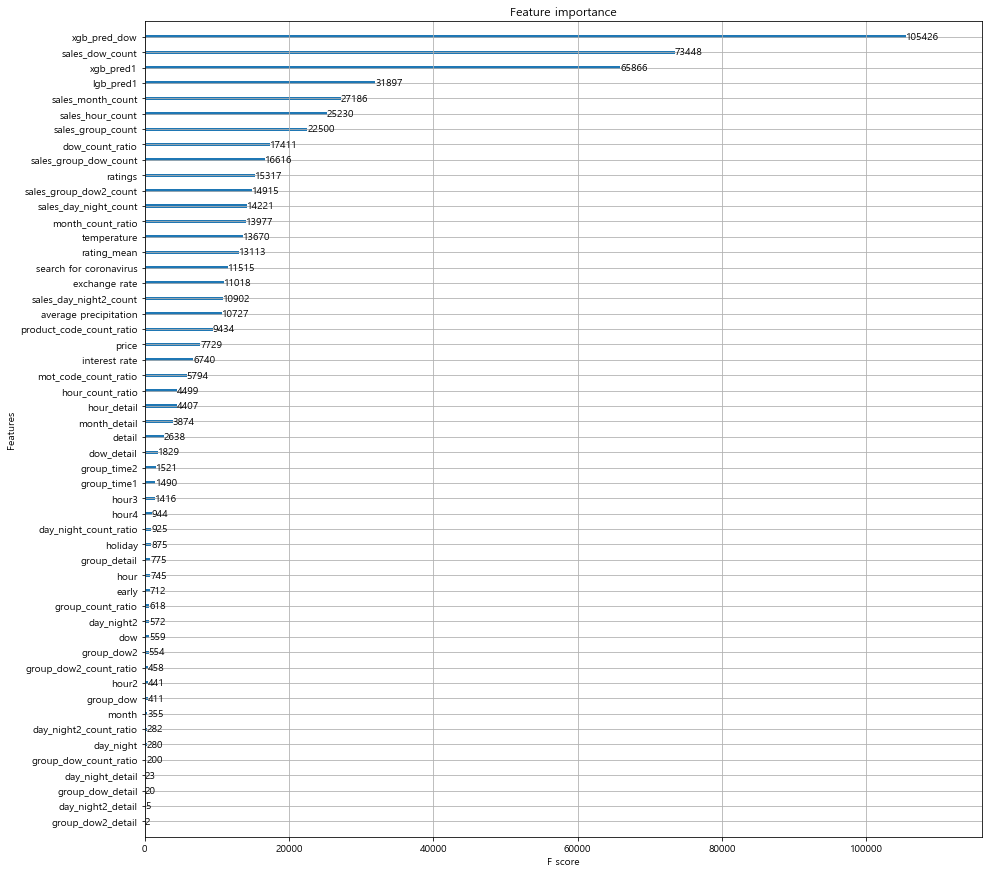

In [264]:
plt.rcParams["figure.figsize"] = (15, 15)
xgb.plot_importance(xgb_model_final)

In [265]:
d_test = xgb.DMatrix(test_X)
xgb_pred_final = xgb_model_final.predict(d_test)
xgb_pred_final

array([  13.444525 ,   46.292347 ,  621.826    , ...,   47.45391  ,
       1606.9865   ,    5.2460933], dtype=float32)

In [266]:
MAPE(test_y, xgb_pred_final)

0.2925831275661391

In [460]:
xgb_pred[xgb_pred < 0]

array([], dtype=float32)

# test set 완성(하는중)

In [464]:
test_set = pd.read_excel('test202006.xlsx')

In [465]:
test_set.columns

Index(['date', 'exposure', 'mot_code', 'product_code', 'product_name',
       'product_detail', 'group', 'price', 'tot_price', 'hour', 'dow', 'month',
       'group_time2', 'group_time1', 'early', 'detail', 'day_night',
       'group_dow', 'search for coronavirus', 'exchange rate', 'interest rate',
       'average precipitation', 'temperature', 'day_night2', 'group2',
       'holiday', 'hour2', 'hour3', 'hour4'],
      dtype='object')

In [466]:
test_set.shape

(2891, 29)

In [467]:
test_set

,date,exposure,mot_code,product_code,product_name,product_detail,group,price,tot_price,hour,...,exchange rate,interest rate,average precipitation,temperature,day_night2,group2,holiday,hour2,hour3,hour4
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,6,...,1237.6,0.7,0.3875,17.98,오전,1,0,6,C,B
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,6,...,1237.6,0.7,0.3875,17.98,오전,1,0,6,C,B
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,7,...,1237.6,0.7,0.3875,18.45,오전,1,0,6,C,B
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,여성속옷,속옷,69900,NaN,7,...,1237.6,0.7,0.3875,18.45,오전,1,0,6,C,B
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,여성속옷,속옷,69900,NaN,7,...,1237.6,0.7,0.3875,18.45,오전,1,0,6,C,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,2020-07-01 00:20:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,무형,0,NaN,0,...,NaN,NaN,NaN,NaN,밤,1,0,6,C,B
2887,2020-07-01 00:40:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,무형,0,NaN,0,...,NaN,NaN,NaN,NaN,밤,1,0,6,C,B
2888,2020-07-01 01:00:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,무형,0,NaN,1,...,NaN,NaN,NaN,NaN,밤,1,0,6,C,B
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,상의,의류,69900,NaN,1,...,NaN,NaN,NaN,NaN,밤,1,0,6,C,B


In [468]:
test_set = test_set[test_set['group']!= '무형'] ## 무형 제거

In [327]:
# test_rating = df[(df['date'] >='2019-06-01 06:00') & (df['date'] <= '2019-07-01 01:40:00')]

# test_rating = test_rating.sort_values('date')[['date','ratings']]

# test_rating

In [469]:
# 요일 그룹 재범주화 (평가데이터)
conditionlist = [
    (test_set['dow'] == '화요일') | (test_set['dow'] == '수요일') | (test_set['dow'] == '월요일'),
    (test_set['dow'] == '목요일') | (test_set['dow'] == '금요일'),
    (test_set['dow'] == '토요일') | (test_set['dow'] == '일요일')]
choicelist = ['월화수','목금','토일']
test_set['group_dow2'] = np.select(conditionlist, choicelist, default='Not Specified')

In [470]:
# 변수 별 빈도수 비율(1)
group_count_ratio = pd.DataFrame(test_set['group'].value_counts()/35378)
group_count_ratio.reset_index(inplace = True)
group_count_ratio.rename(columns = {'index':'group','group':'group_count_ratio'},inplace = True)
test_set = pd.merge(test_set,group_count_ratio, on = 'group',how = 'left')

# 변수 별 빈도수 비율(2)
dow_count_ratio = pd.DataFrame(test_set['dow'].value_counts()/35378)
dow_count_ratio.reset_index(inplace = True)
dow_count_ratio.rename(columns = {'index':'dow','dow':'dow_count_ratio'},inplace = True)
test_set = pd.merge(test_set,dow_count_ratio, on = 'dow',how = 'left')

# 변수 별 빈도수 비율(3)
group_dow_count_ratio = pd.DataFrame(test_set['group_dow'].value_counts()/35378)
group_dow_count_ratio.reset_index(inplace = True)
group_dow_count_ratio.rename(columns = {'index':'group_dow','group_dow':'group_dow_count_ratio'},inplace = True)
test_set = pd.merge(test_set,group_dow_count_ratio, on = 'group_dow',how = 'left')

# 변수 별 빈도수 비율(4)
group_dow2_count_ratio = pd.DataFrame(test_set['group_dow2'].value_counts()/35378)
group_dow2_count_ratio.reset_index(inplace = True)
group_dow2_count_ratio.rename(columns = {'index':'group_dow2','group_dow2':'group_dow2_count_ratio'},inplace = True)
test_set = pd.merge(test_set,group_dow2_count_ratio, on = 'group_dow2',how = 'left')

# 변수 별 빈도수 비율(5)
hour_count_ratio = pd.DataFrame(test_set['hour'].value_counts()/35378)
hour_count_ratio.reset_index(inplace = True)
hour_count_ratio.rename(columns = {'index':'hour','hour':'hour_count_ratio'},inplace = True)
test_set = pd.merge(test_set,hour_count_ratio, on = 'hour',how = 'left')

# 변수 별 빈도수 비율(6)
day_night_count_ratio = pd.DataFrame(test_set['day_night'].value_counts()/35378)
day_night_count_ratio.reset_index(inplace = True)
day_night_count_ratio.rename(columns = {'index':'day_night','day_night':'day_night_count_ratio'},inplace = True)
test_set = pd.merge(test_set,day_night_count_ratio, on = 'day_night',how = 'left')

# 변수 별 빈도수 비율(7)
day_night2_count_ratio = pd.DataFrame(test_set['day_night2'].value_counts()/35378)
day_night2_count_ratio.reset_index(inplace = True)
day_night2_count_ratio.rename(columns = {'index':'day_night2','day_night2':'day_night2_count_ratio'},inplace = True)
test_set = pd.merge(test_set,day_night2_count_ratio, on = 'day_night2',how = 'left')

# 변수 별 빈도수 비율(8)
mot_code_count_ratio = pd.DataFrame(test_set['mot_code'].value_counts()/35378)
mot_code_count_ratio.reset_index(inplace = True)
mot_code_count_ratio.rename(columns = {'index':'mot_code','mot_code':'mot_code_count_ratio'},inplace = True)
test_set = pd.merge(test_set,mot_code_count_ratio, on = 'mot_code',how = 'left')

# 변수 별 빈도수 비율(9)
product_code_count_ratio = pd.DataFrame(test_set['product_code'].value_counts()/35378)
product_code_count_ratio.reset_index(inplace = True)
product_code_count_ratio.rename(columns = {'index':'product_code','product_code':'product_code_count_ratio'},inplace = True)
test_set = pd.merge(test_set,product_code_count_ratio, on = 'product_code',how = 'left')

# 변수 별 빈도수 비율(10)
month_count_ratio = pd.DataFrame(test_set['month'].value_counts()/35378)
month_count_ratio.reset_index(inplace = True)
month_count_ratio.rename(columns = {'index':'month','month':'month_count_ratio'},inplace = True)
test_set = pd.merge(test_set,month_count_ratio, on = 'month',how = 'left')

In [471]:
df.head(1)

,date,exposure,mot_code,product_code,product_name,group,product_detail,brand,price,tot_price,...,dow_count_ratio,group_dow_count_ratio,group_dow2_count_ratio,hour_count_ratio,day_night_count_ratio,day_night2_count_ratio,mot_code_count_ratio,product_code_count_ratio,month_count_ratio,group_detail_y
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,상의,테이트,39900,2099000,...,0.14639,0.434818,0.432642,0.037566,0.272457,0.272457,0.00342,0.000141,0.078043,523.273253


In [472]:
test_set.head(1)

,date,exposure,mot_code,product_code,product_name,product_detail,group,price,tot_price,hour,...,group_count_ratio,dow_count_ratio,group_dow_count_ratio,group_dow2_count_ratio,hour_count_ratio,day_night_count_ratio,day_night2_count_ratio,mot_code_count_ratio,product_code_count_ratio,month_count_ratio
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,6,...,0.004551,0.010148,0.010148,0.031997,0.002374,0.020663,0.020663,0.000085,0.000085,0.076545


In [473]:
# 상품군별 빈도수 대비 판매량
sales_group_count = df[['sales','group']]
sales_group_count.set_index('group',inplace = True)
sales_group_count['count'] = df['group'].value_counts()
sales_group_count['sales_group_count'] = sales_group_count['sales'] / sales_group_count['count']
sales_group_count = sales_group_count.groupby('group').mean()
sales_group_count = sales_group_count['sales_group_count']
test_set = pd.merge(test_set,sales_group_count, on = 'group',how = 'left')


# 시간대별 빈도수 대비 판매량
sales_hour_count = df[['sales','hour']]
sales_hour_count.set_index('hour',inplace = True)
sales_hour_count['count'] = df['hour'].value_counts()
sales_hour_count['sales_hour_count'] = sales_hour_count['sales'] / sales_hour_count['count']
sales_hour_count = sales_hour_count.groupby('hour').mean()
sales_hour_count = sales_hour_count['sales_hour_count']
test_set = pd.merge(test_set,sales_hour_count, on = 'hour',how = 'left')


# 요일별 빈도수 대비 판매량
sales_dow_count = df[['sales','dow']]
sales_dow_count.set_index('dow',inplace = True)
sales_dow_count['count'] = df['dow'].value_counts()
sales_dow_count['sales_dow_count'] = sales_dow_count['sales'] / sales_dow_count['count']
sales_dow_count = sales_dow_count.groupby('dow').mean()
sales_dow_count = sales_dow_count['sales_dow_count']
test_set = pd.merge(test_set,sales_dow_count, on = 'dow',how = 'left')


# 시간대별 빈도수 대비 판매량
sales_day_night_count = df[['sales','day_night']]
sales_day_night_count.set_index('day_night',inplace = True)
sales_day_night_count['count'] = df['day_night'].value_counts()
sales_day_night_count['sales_day_night_count'] = sales_day_night_count['sales'] / sales_day_night_count['count']
sales_day_night_count = sales_day_night_count.groupby('day_night').mean()
sales_day_night_count = sales_day_night_count['sales_day_night_count']
test_set = pd.merge(test_set,sales_day_night_count, on = 'day_night',how = 'left')


# 시간대별 빈도수 대비 판매량2
sales_day_night2_count = df[['sales','day_night2']]
sales_day_night2_count.set_index('day_night2',inplace = True)
sales_day_night2_count['count'] = df['day_night2'].value_counts()
sales_day_night2_count['sales_day_night2_count'] = sales_day_night2_count['sales'] / sales_day_night2_count['count']
sales_day_night2_count = sales_day_night2_count.groupby('day_night2').mean()
sales_day_night2_count = sales_day_night2_count['sales_day_night2_count']
test_set = pd.merge(test_set,sales_day_night2_count, on = 'day_night2',how = 'left')

# 그룹요일별 빈도수 대비 판매량
sales_group_dow_count = df[['sales','group_dow']]
sales_group_dow_count.set_index('group_dow',inplace = True)
sales_group_dow_count['count'] = df['group_dow'].value_counts()
sales_group_dow_count['sales_group_dow_count'] = sales_group_dow_count['sales'] / sales_group_dow_count['count']
sales_group_dow_count = sales_group_dow_count.groupby('group_dow').mean()
sales_group_dow_count = sales_group_dow_count['sales_group_dow_count']
test_set = pd.merge(test_set,sales_group_dow_count, on = 'group_dow',how = 'left')


# 그룹요일별 빈도수 대비 판매량2
sales_group_dow2_count = df[['sales','group_dow2']]
sales_group_dow2_count.set_index('group_dow2',inplace = True)
sales_group_dow2_count['count'] = df['group_dow2'].value_counts()
sales_group_dow2_count['sales_group_dow2_count'] = sales_group_dow2_count['sales'] / sales_group_dow2_count['count']
sales_group_dow2_count = sales_group_dow2_count.groupby('group_dow2').mean()
sales_group_dow2_count = sales_group_dow2_count['sales_group_dow2_count']
test_set = pd.merge(test_set,sales_group_dow2_count, on = 'group_dow2',how = 'left')

# 월별 빈도수 대비 판매량

sales_month_count = df[['sales','month']]
sales_month_count.set_index('month',inplace = True)
sales_month_count['count'] = df['month'].value_counts()
sales_month_count['sales_month_count'] = sales_month_count['sales'] / sales_month_count['count']
sales_month_count = sales_month_count.groupby('month').mean()
sales_month_count = sales_month_count['sales_month_count']
test_set = pd.merge(test_set,sales_month_count, on = 'month',how = 'left')

In [474]:
test_set

,date,exposure,mot_code,product_code,product_name,product_detail,group,price,tot_price,hour,...,product_code_count_ratio,month_count_ratio,sales_group_count,sales_hour_count,sales_dow_count,sales_day_night_count,sales_day_night2_count,sales_group_dow_count,sales_group_dow2_count,sales_month_count
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,6,...,0.000085,0.076545,0.088885,0.185429,0.062288,0.036355,0.036355,0.062288,0.020084,0.106853
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,6,...,0.000085,0.076545,0.088885,0.185429,0.062288,0.036355,0.036355,0.062288,0.020084,0.106853
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,7,...,0.000085,0.076545,0.088885,0.269284,0.062288,0.036355,0.036355,0.062288,0.020084,0.106853
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,여성속옷,속옷,69900,NaN,7,...,0.000254,0.076545,0.093212,0.269284,0.062288,0.036355,0.036355,0.062288,0.020084,0.106853
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,여성속옷,속옷,69900,NaN,7,...,0.000254,0.076545,0.093212,0.269284,0.062288,0.036355,0.036355,0.062288,0.020084,0.106853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,2020-07-01 00:10:00,10.000000,100099,200274,라쉬반 FC바로셀로나 드로즈 8종,남성속옷,속옷,119000,NaN,0,...,0.000678,0.000226,0.093212,0.153630,0.058367,0.065812,0.012036,0.019945,0.020084,0.097643
2712,2020-07-01 00:10:00,10.000000,100099,200273,[일시불]라쉬반 FC바로셀로나 드로즈 패키지,남성속옷,속옷,99000,NaN,0,...,0.000678,0.000226,0.093212,0.153630,0.058367,0.065812,0.012036,0.019945,0.020084,0.097643
2713,2020-07-01 00:10:00,10.000000,100099,200272,[무이자]라쉬반 FC바로셀로나 드로즈 패키지,남성속옷,속옷,119000,NaN,0,...,0.000678,0.000226,0.093212,0.153630,0.058367,0.065812,0.012036,0.019945,0.020084,0.097643
2714,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,상의,의류,69900,NaN,1,...,0.000057,0.000226,0.088885,0.116625,0.058367,0.065812,0.012036,0.019945,0.020084,0.097643


In [475]:
# 디테일 간 판매수량 차이 비율(1)
group_detail = pd.DataFrame(df.groupby(['detail','group'])['sales'].mean())
group_detail.reset_index(inplace = True)
group_detail_0 = group_detail[group_detail['detail'] == 0].set_index('group').drop(columns = ['detail'])
group_detail_1 = group_detail[group_detail['detail'] == 1].set_index('group').drop(columns = ['detail'])
group_detail = group_detail_1 - group_detail_0 / group_detail_0
group_detail.reset_index(inplace = True)
group_detail.rename({'sales':'group_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,group_detail, on = 'group',how = 'left')

# 디테일 간 판매수량 차이 (2)
hour_detail = pd.DataFrame(df.groupby(['detail','hour'])['sales'].mean())
hour_detail.reset_index(inplace = True)
hour_detail_0 = hour_detail[hour_detail['detail'] == 0].set_index('hour').drop(columns = ['detail'])
hour_detail_1 = hour_detail[hour_detail['detail'] == 1].set_index('hour').drop(columns = ['detail'])
hour_detail = hour_detail_1 - hour_detail_0 / hour_detail_0
hour_detail.reset_index(inplace = True)
hour_detail.rename({'sales':'hour_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,hour_detail, on = 'hour',how = 'left')

# 디테일 간 판매수량 차이 (3)
dow_detail = pd.DataFrame(df.groupby(['detail','dow'])['sales'].mean())
dow_detail.reset_index(inplace = True)
dow_detail_0 = dow_detail[dow_detail['detail'] == 0].set_index('dow').drop(columns = ['detail'])
dow_detail_1 = dow_detail[dow_detail['detail'] == 1].set_index('dow').drop(columns = ['detail'])
dow_detail = dow_detail_1 - dow_detail_0 / dow_detail_0
dow_detail.reset_index(inplace = True)
dow_detail.rename({'sales':'dow_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,dow_detail, on = 'dow',how = 'left')

# 디테일 간 판매수량 차이 (4)
day_night_detail = pd.DataFrame(df.groupby(['detail','day_night'])['sales'].mean())
day_night_detail.reset_index(inplace = True)
day_night_detail_0 = day_night_detail[day_night_detail['detail'] == 0].set_index('day_night').drop(columns = ['detail'])
day_night_detail_1 = day_night_detail[day_night_detail['detail'] == 1].set_index('day_night').drop(columns = ['detail'])
day_night_detail = day_night_detail_1 - day_night_detail_0 / day_night_detail_0
day_night_detail.reset_index(inplace = True)
day_night_detail.rename({'sales':'day_night_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,day_night_detail, on = 'day_night',how = 'left')

# 디테일 간 판매수량 차이 (5)
day_night2_detail = pd.DataFrame(df.groupby(['detail','day_night2'])['sales'].mean())
day_night2_detail.reset_index(inplace = True)
day_night2_detail_0 = day_night2_detail[day_night2_detail['detail'] == 0].set_index('day_night2').drop(columns = ['detail'])
day_night2_detail_1 = day_night2_detail[day_night2_detail['detail'] == 1].set_index('day_night2').drop(columns = ['detail'])
day_night2_detail = day_night2_detail_1 - day_night2_detail_0 / day_night2_detail_0
day_night2_detail.reset_index(inplace = True)
day_night2_detail.rename({'sales':'day_night2_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,day_night2_detail, on = 'day_night2',how = 'left')

# 디테일 간 판매수량 차이 (6)
group_dow_detail = pd.DataFrame(df.groupby(['detail','group_dow'])['sales'].mean())
group_dow_detail.reset_index(inplace = True)
group_dow_detail_0 = group_dow_detail[group_dow_detail['detail'] == 0].set_index('group_dow').drop(columns = ['detail'])
group_dow_detail_1 = group_dow_detail[group_dow_detail['detail'] == 1].set_index('group_dow').drop(columns = ['detail'])
group_dow_detail = group_dow_detail_1 - group_dow_detail_0 / group_dow_detail_0
group_dow_detail.reset_index(inplace = True)
group_dow_detail.rename({'sales':'group_dow_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,group_dow_detail, on = 'group_dow',how = 'left')

# 디테일 간 판매수량 차이 (7)
group_dow2_detail = pd.DataFrame(df.groupby(['detail','group_dow2'])['sales'].mean())
group_dow2_detail.reset_index(inplace = True)
group_dow2_detail_0 = group_dow2_detail[group_dow2_detail['detail'] == 0].set_index('group_dow2').drop(columns = ['detail'])
group_dow2_detail_1 = group_dow2_detail[group_dow2_detail['detail'] == 1].set_index('group_dow2').drop(columns = ['detail'])
group_dow2_detail = group_dow2_detail_1 - group_dow2_detail_0 / group_dow2_detail_0
group_dow2_detail.reset_index(inplace = True)
group_dow2_detail.rename({'sales':'group_dow2_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,group_dow2_detail, on = 'group_dow2',how = 'left')

# 디테일 간 판매수량 차이 (8)
month_detail = pd.DataFrame(df.groupby(['detail','month'])['sales'].mean())
month_detail.reset_index(inplace = True)
month_detail_0 = month_detail[month_detail['detail'] == 0].set_index('month').drop(columns = ['detail'])
month_detail_1 = month_detail[month_detail['detail'] == 1].set_index('month').drop(columns = ['detail'])
month_detail = month_detail_1 - month_detail_0 / month_detail_0
month_detail.reset_index(inplace = True)
month_detail.rename({'sales':'month_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,month_detail, on = 'month',how = 'left')

In [490]:
test_xgb_dow = [xgb_pred_tue.mean(),xgb_pred_wen.mean(),xgb_pred_thu.mean(),xgb_pred_fri.mean(),xgb_pred_sat.mean(),xgb_pred_sun.mean(),xgb_pred_mon.mean()]
test_xgb_dow = pd.DataFrame(test_xgb_dow)
test_xgb_dow['dow']=df['dow'].unique()
test_set = 

,xgb_pred_dow,dow
0,368.329803,화요일
1,351.708038,수요일
2,368.927887,목요일
3,310.030029,금요일
4,389.696594,토요일
5,385.879333,일요일
6,394.553040,월요일


In [476]:
# 모델에 필요없는 변수 제거
test_set.drop(columns = ['date','exposure','mot_code','product_code','product_name','group2'],inplace = True)

In [477]:
test_set_sales = test_set['tot_price']
test_set.drop(columns = ['tot_price'],inplace = True)

In [478]:
print(test_set.shape)
print(train_X.shape)

(2716, 48)
(10632, 55)


In [455]:
test_set.columns

Index(['product_detail', 'group', 'price', 'hour', 'dow', 'month',
       'group_time2', 'group_time1', 'early', 'detail', 'day_night',
       'group_dow', 'search for coronavirus', 'exchange rate', 'interest rate',
       'average precipitation', 'temperature', 'day_night2', 'holiday',
       'hour2', 'hour3', 'hour4', 'group_dow2', 'mot_code_count_ratio',
       'dow_count_ratio', 'hour_count_ratio', 'group_dow_count_ratio',
       'group_dow2_count_ratio', 'day_night_count_ratio',
       'product_code_count_ratio', 'sales_group_count', 'sales_hour_count',
       'sales_dow_count', 'sales_day_night_count', 'sales_day_night2_count',
       'sales_group_dow_count', 'sales_group_dow2_count', 'sales_month_count',
       'group_detail', 'hour_detail', 'dow_detail', 'day_night_detail',
       'day_night2_detail', 'group_dow_detail', 'group_dow2_detail',
       'month_detail'],
      dtype='object')

In [458]:
train_X.columns

Index(['group', 'ratings', 'rating_mean', 'price', 'product_detail', 'hour',
       'dow', 'group_dow', 'group_dow2', 'early', 'day_night', 'group_time1',
       'group_time2', 'detail', 'day_night2', 'holiday', 'month', 'hour2',
       'hour3', 'hour4', 'cluster_count', 'sales_group_count',
       'sales_hour_count', 'sales_dow_count', 'sales_day_night_count',
       'sales_day_night2_count', 'sales_group_dow_count',
       'sales_group_dow2_count', 'sales_month_count', 'dow_count_ratio',
       'group_dow_count_ratio', 'group_count_ratio', 'group_dow2_count_ratio',
       'hour_count_ratio', 'day_night_count_ratio', 'mot_code_count_ratio',
       'product_code_count_ratio', 'day_night2_count_ratio',
       'month_count_ratio', 'group_detail', 'hour_detail', 'dow_detail',
       'day_night_detail', 'day_night2_detail', 'group_dow_detail',
       'group_dow2_detail', 'month_detail', 'search for coronavirus',
       'exchange rate', 'interest rate', 'average precipitation',
       'temp

In [ ]:
'product_detail', 'group', 'price', 'hour', 'dow', 'month',
       'group_time2', 'group_time1', 'early', 'detail', 'day_night',
       'group_dow', 'search for coronavirus', 'exchange rate', 'interest rate',
       'average precipitation', 'temperature', 'day_night2', 'holiday',
       'hour2', 'hour3', 'hour4', 'group_dow2',
        
        'mot_code_count_ratio',
       'dow_count_ratio', 'hour_count_ratio', 'group_dow_count_ratio',
       'group_dow2_count_ratio', 'day_night_count_ratio',
       'product_code_count_ratio',
       'group_detail', 'hour_detail', 'dow_detail', 'day_night_detail',
       'day_night2_detail', 'group_dow_detail', 'group_dow2_detail',
       'month_detail'
        
        
        'ratings', 'rating_mean',, 

  'cluster_count', 
      , 'dow_count_ratio',
       'group_dow_count_ratio', 'group_count_ratio', 'group_dow2_count_ratio',
       
 'day_night2_count_ratio',
       'month_count_ratio', 'group_detail', 'hour_detail', 'dow_detail',
       'day_night_detail', 'day_night2_detail', 'group_dow_detail',
       'group_dow2_detail', 'month_detail', 'search for coronavirus',
       'exchange rate', 'interest rate', 'average precipitation',
       'temperature', 'xgb_pred1', 'lgb_pred1', 'xgb_pred_dow'